# Multimodal Brain-to-Text Experiment: Audio as Training-Time Supervision

## Context: Baseline Pipeline

**Baseline Approach**: 
- Input: Neural activity signals (512 channels, 20ms bins)
- Model: LSTM encoder → CTC decoder → Phoneme predictions
- Training: Neural data → Phoneme labels (supervised learning)
- Inference: Neural data only → Phoneme predictions

**What We're Changing**:
- Add audio features during training (generated from text labels via TTS)
- Use cross-modal attention to align neural and audio features
- Train with both modalities, but evaluate with neural-only inputs
- Goal: Audio acts as "teacher signal" to improve neural encoder representations

**Why This Makes Sense**:
- Audio contains acoustic-phonetic information (formants, prosody, timing)
- Cross-modal learning may help neural encoder learn better features
- At test time, improved encoder should decode better from neural signals alone

## Research Question

Does training with audio features improve neural-only decoding performance?

**Hypothesis**: Models trained with audio supervision will achieve lower PER than baseline when both are evaluated on neural-only inputs.

**Design**:
- Training: Neural + Audio features (TTS-generated)
- Evaluation: Neural-only inputs (realistic BCI scenario)
- Comparison: Baseline vs. Multimodal models (same data, splits, hyperparameters)

---


## Experimental Design

**Dataset**: 3 sessions (~300-500 sentences)

**Models**:
1. **Baseline**: Neural-only LSTM + CTC
2. **Mel-only**: Neural + Mel-spectrogram features
3. **Wav2Vec2-only**: Neural + Wav2Vec2Phoneme features  
4. **Combined**: Neural + Mel + Wav2Vec2Phoneme features

**Training**: All models use same hyperparameters, data splits, random seeds

**Evaluation**: All models tested with neural-only inputs (no audio)

**Metrics**: Phoneme Error Rate (PER) on test set

**Limitations**:
- TTS audio may not match attempted speech (domain mismatch)
- Temporal alignment uncertainty (neural includes silence, TTS doesn't)
- Small sample size (3 sessions)

**Interpretation**:
- If multimodal models outperform baseline: Audio supervision helps (real audio would likely help more)
- If similar performance: May indicate sufficient neural information or domain mismatch issues
- If baseline outperforms: Audio features may be distracting or model needs improvement

---


## 1. Setup and Imports


In [118]:
import os
import sys
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import soundfile as sf
from gtts import gTTS  # Google Text-to-Speech (free)
import io

# Transformers for Wav2Vec2Phoneme (use Wav2Vec2Model for feature extraction)
from transformers import Wav2Vec2Model, Wav2Vec2Processor

# Add project root to path
project_root = Path.cwd().parent  # Go up from experiments/ to project root
sys.path.insert(0, str(project_root))

from data.tokenizer import PhonemeTokenizer
from utils.evaluation import compute_wer

print("Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS (Apple Silicon GPU) available: {torch.backends.mps.is_available() if hasattr(torch.backends, 'mps') else False}")
if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    print(f"MPS built: {torch.backends.mps.is_built()}")


Imports successful
PyTorch version: 2.9.1
CUDA available: False
MPS (Apple Silicon GPU) available: True
MPS built: True


## 2. Configuration

Define experiment parameters.


In [ ]:
# Experiment configuration
CONFIG = {
    # Data
    'data_dir': os.getenv('BRAIN_TO_TEXT_DATA_DIR', '../dataset/t15_copyTask_neuralData/hdf5_data_final'),
    'session_name': 't15.2023.08.13',  # Use one session for small-scale experiment
    'max_trials': 100,  # Limit to ~100 sentences for small-scale
    'train_split': 0.7,
    'val_split': 0.15,
    'test_split': 0.15,
    
    # Audio generation
    'audio_dir': 'audio_cache',  # Cache generated audio
    'sample_rate': 16000,  # 16kHz for speech
    'audio_feature_dim': 80,  # Mel-spectrogram features
    'audio_hop_length': 160,  # ~10ms frames (will align with neural 20ms bins)
    
    # Model
    'neural_input_size': 512,
    'hidden_size': 256,
    'num_layers': 2,
    'num_phonemes': 41,  # 40 phonemes + blank
    'dropout': 0.2,
    
    # Training
    'batch_size': 8,
    'learning_rate': 1e-3,
    'num_epochs': 20,
    'device': None,  # Will be set below based on availability
    'seed': 42,
}

# Device selection: MPS (Apple Silicon) > CUDA > CPU
# MPS provides GPU acceleration on Apple Silicon (M1/M2/M3) chips
if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    CONFIG['device'] = 'mps'
    print("Using MPS (Apple Silicon GPU) - M3 Max")
    print("Note: CTC loss will be computed on CPU (MPS limitation), but forward/backward passes use GPU")
elif torch.cuda.is_available():
    CONFIG['device'] = 'cuda'
    print("Using CUDA GPU")
else:
    CONFIG['device'] = 'cpu'
    print("Using CPU (no GPU available)")

# Set random seeds for reproducibility
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

# Create audio cache directory
os.makedirs(CONFIG['audio_dir'], exist_ok=True)

print(f"\nConfiguration loaded")
print(f"Device: {CONFIG['device']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Epochs: {CONFIG['num_epochs']}")


🚀 Using MPS (Apple Silicon GPU) - M3 Max
   Note: CTC loss will be computed on CPU (MPS limitation), but forward/backward passes use GPU

✅ Configuration loaded
   Device: mps
   Batch size: 8
   Learning rate: 0.001
   Epochs: 20


## 3. Data Loading

Load neural data from **3 sessions** and combine them for expanded study.

**Sessions**: t15.2023.08.13, t15.2023.08.18, t15.2023.08.20


In [ ]:
def load_session_data(session_path, split='train', max_trials=None):
    """Load neural features, phoneme labels, and text labels from a session."""
    file_path = os.path.join(session_path, f"data_{split}.hdf5")
    
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return [], [], [], []
    
    neural_features = []
    phoneme_labels = []
    text_labels = []
    trial_keys = []
    
    with h5py.File(file_path, 'r') as f:
        keys = sorted(list(f.keys()))
        
        if max_trials:
            keys = keys[:max_trials]
        
        for key in tqdm(keys, desc=f"Loading {split} data"):
            trial = f[key]
            
            # Load neural features
            if 'input_features' in trial:
                neural = trial['input_features'][:]  # (T, 512)
                neural_features.append(neural)
                
                # Load phoneme labels (for training targets)
                if 'seq_class_ids' in trial:
                    phonemes = trial['seq_class_ids'][:]  # (P,)
                    phoneme_labels.append(phonemes)
                else:
                    phoneme_labels.append(None)
                
                # Load text label (for audio generation)
                if 'sentence_label' in trial.attrs:
                    text = trial.attrs['sentence_label']
                    if isinstance(text, bytes):
                        text = text.decode('utf-8')
                    text_labels.append(text)
                    trial_keys.append(key)
    
    return neural_features, phoneme_labels, text_labels, trial_keys

# Load data from multiple sessions
session_names = ['t15.2023.08.13', 't15.2023.08.18', 't15.2023.08.20']
max_trials_per_session = None  # Use all trials

train_neural, train_phonemes, train_texts, train_keys = [], [], [], []
val_neural, val_phonemes, val_texts, val_keys = [], [], [], []
test_neural, test_phonemes, test_texts, test_keys = [], [], [], []

for session_name in session_names:
    session_path = os.path.join(CONFIG['data_dir'], session_name)
    
    if not os.path.exists(session_path):
        print(f"Session not found: {session_path}, skipping...")
        continue
    
    print(f"\nLoading session: {session_name}")
    
    # Load all splits from this session
    sess_train_neural, sess_train_phonemes, sess_train_texts, sess_train_keys = load_session_data(
        session_path, 'train', max_trials_per_session)
    sess_val_neural, sess_val_phonemes, sess_val_texts, sess_val_keys = load_session_data(
        session_path, 'val', max_trials_per_session)
    sess_test_neural, sess_test_phonemes, sess_test_texts, sess_test_keys = load_session_data(
        session_path, 'test', max_trials_per_session)
    
    # Combine with existing data
    train_neural.extend(sess_train_neural)
    train_phonemes.extend(sess_train_phonemes)
    train_texts.extend(sess_train_texts)
    train_keys.extend([f"{session_name}_{k}" for k in sess_train_keys])
    
    val_neural.extend(sess_val_neural)
    val_phonemes.extend(sess_val_phonemes)
    val_texts.extend(sess_val_texts)
    val_keys.extend([f"{session_name}_{k}" for k in sess_val_keys])
    
    test_neural.extend(sess_test_neural)
    test_phonemes.extend(sess_test_phonemes)
    test_texts.extend(sess_test_texts)
    test_keys.extend([f"{session_name}_{k}" for k in sess_test_keys])
    
    print(f"  Session {session_name}: Train={len(sess_train_neural)}, Val={len(sess_val_neural)}, Test={len(sess_test_neural)}")

print(f"\nTotal data loaded from {len(session_names)} sessions:")
print(f"  Train: {len(train_neural)} trials")
print(f"  Val: {len(val_neural)} trials")
print(f"  Test: {len(test_neural)} trials")
print(f"\nSample text labels:")
for i, text in enumerate(train_texts[:3]):
    print(f"  {i+1}. '{text}' (neural shape: {train_neural[i].shape}, phonemes: {len(train_phonemes[i]) if train_phonemes[i] is not None else 0})")



📂 Loading session: t15.2023.08.13


Loading test data: 100%|██████████| 35/35 [00:00<00:00, 492.25it/s]


  Session t15.2023.08.13: Train=348, Val=35, Test=35

📂 Loading session: t15.2023.08.18


Loading test data: 100%|██████████| 50/50 [00:00<00:00, 550.33it/s]


  Session t15.2023.08.18: Train=197, Val=49, Test=50

📂 Loading session: t15.2023.08.20


Loading test data: 100%|██████████| 49/49 [00:00<00:00, 676.08it/s]

  Session t15.2023.08.20: Train=278, Val=48, Test=49

✅ Total data loaded from 3 sessions:
  Train: 823 trials
  Val: 132 trials
  Test: 134 trials

Sample text labels:
  1. 'Which is most unfortunate because we all lose out.' (neural shape: (1023, 512), phonemes: 500)
  2. 'I had a nineteen seventy eight version before this one.' (neural shape: (1210, 512), phonemes: 500)
  3. 'You get back into a political thing.' (neural shape: (867, 512), phonemes: 500)


## 4. Audio Generation via TTS

Generate synthetic audio from text labels using Google Text-to-Speech (gTTS) - a free API.

**Rationale**: 
- TTS provides acoustic features that complement neural signals
- Audio contains timing, prosody, and phonetic information
- Synthetic audio acts as a form of data augmentation

**Note**: gTTS requires internet connection. Audio files are cached to avoid regenerating.


In [121]:
def generate_audio_from_text(text, output_path, lang='en', slow=False):
    """Generate audio from text using gTTS and save to file."""
    if os.path.exists(output_path):
        return output_path  # Use cached audio
    
    try:
        tts = gTTS(text=text, lang=lang, slow=slow)
        tts.save(output_path)
        return output_path
    except Exception as e:
        return None

def generate_all_audio(texts, trial_keys, split_name):
    """Generate audio for all text labels."""
    if len(texts) == 0:
        return []
    
    audio_paths = []
    for i, (text, key) in enumerate(tqdm(zip(texts, trial_keys), desc=f"Generating {split_name} audio", total=len(texts))):
        audio_filename = f"{split_name}_{i:04d}.mp3"
        audio_path = os.path.join(CONFIG['audio_dir'], audio_filename)
        result = generate_audio_from_text(text, audio_path)
        audio_paths.append(result)
    return audio_paths

# Generate audio for all splits
print("Generating audio from text labels (requires internet connection)...")

train_audio_paths = generate_all_audio(train_texts, train_keys, 'train')
val_audio_paths = generate_all_audio(val_texts, val_keys, 'val')
test_audio_paths = generate_all_audio(test_texts, test_keys, 'test')

print(f"Audio generation: Train={sum(1 for p in train_audio_paths if p)}/{len(train_audio_paths)}, "
      f"Val={sum(1 for p in val_audio_paths if p)}/{len(val_audio_paths)}, "
      f"Test={sum(1 for p in test_audio_paths if p)}/{len(test_audio_paths)}")


Generating audio from text labels (requires internet connection)...


Generating val audio: 100%|██████████| 132/132 [00:18<00:00,  7.27it/s]

Audio generation: Train=822/823, Val=132/132, Test=0/0


## 5. Audio Feature Extraction

Extract mel-spectrogram features from audio, aligned to neural timesteps.

**Note**: Neural recordings include silence (~20s), while TTS audio contains only speech (~3-4s). We pad audio with silence to match neural length. Cross-modal attention should handle temporal misalignment.


## 5.5 Data Visualization & Verification

Visualize neural features, audio features, and their alignment.

**Note**: Neural recordings include silence (~20s total), while TTS audio contains only speech (~3-4s). We pad audio with silence to match neural length. Cross-modal attention should learn to handle this temporal misalignment.


DATA VERIFICATION & VISUALIZATION

📝 Sample Trial #1:
   Text: 'Which is most unfortunate because we all lose out.'
   Text length: 50 characters
   Phoneme sequence length: 500
   First 20 phonemes: W IH CH  |  IH Z  |  M OW S T  |  AH N F AO R CH AH N

🧠 Neural Features:
   Shape: (1023, 512) (time_steps × features)
   Time steps: 1023 (~20.46 seconds)
   Feature channels: 512
   Value range: [-2.64, 10.00]
   Mean: -0.00, Std: 1.00

🎵 Audio Features:
   Shape: (1023, 80) (time_frames × mel_bins)
   Time frames: 1023 (aligned with neural)
   Mel bins: 80
   Value range: [-90.00, 0.00]
   ⚠️  Actual audio duration: 3.50s (neural: 20.46s)
   ⚠️  Silence padding: ~82.9% of total duration
   Temporal alignment: ✅ Length matched
   ⚠️  Note: Speech portions may not align perfectly (see visualization)


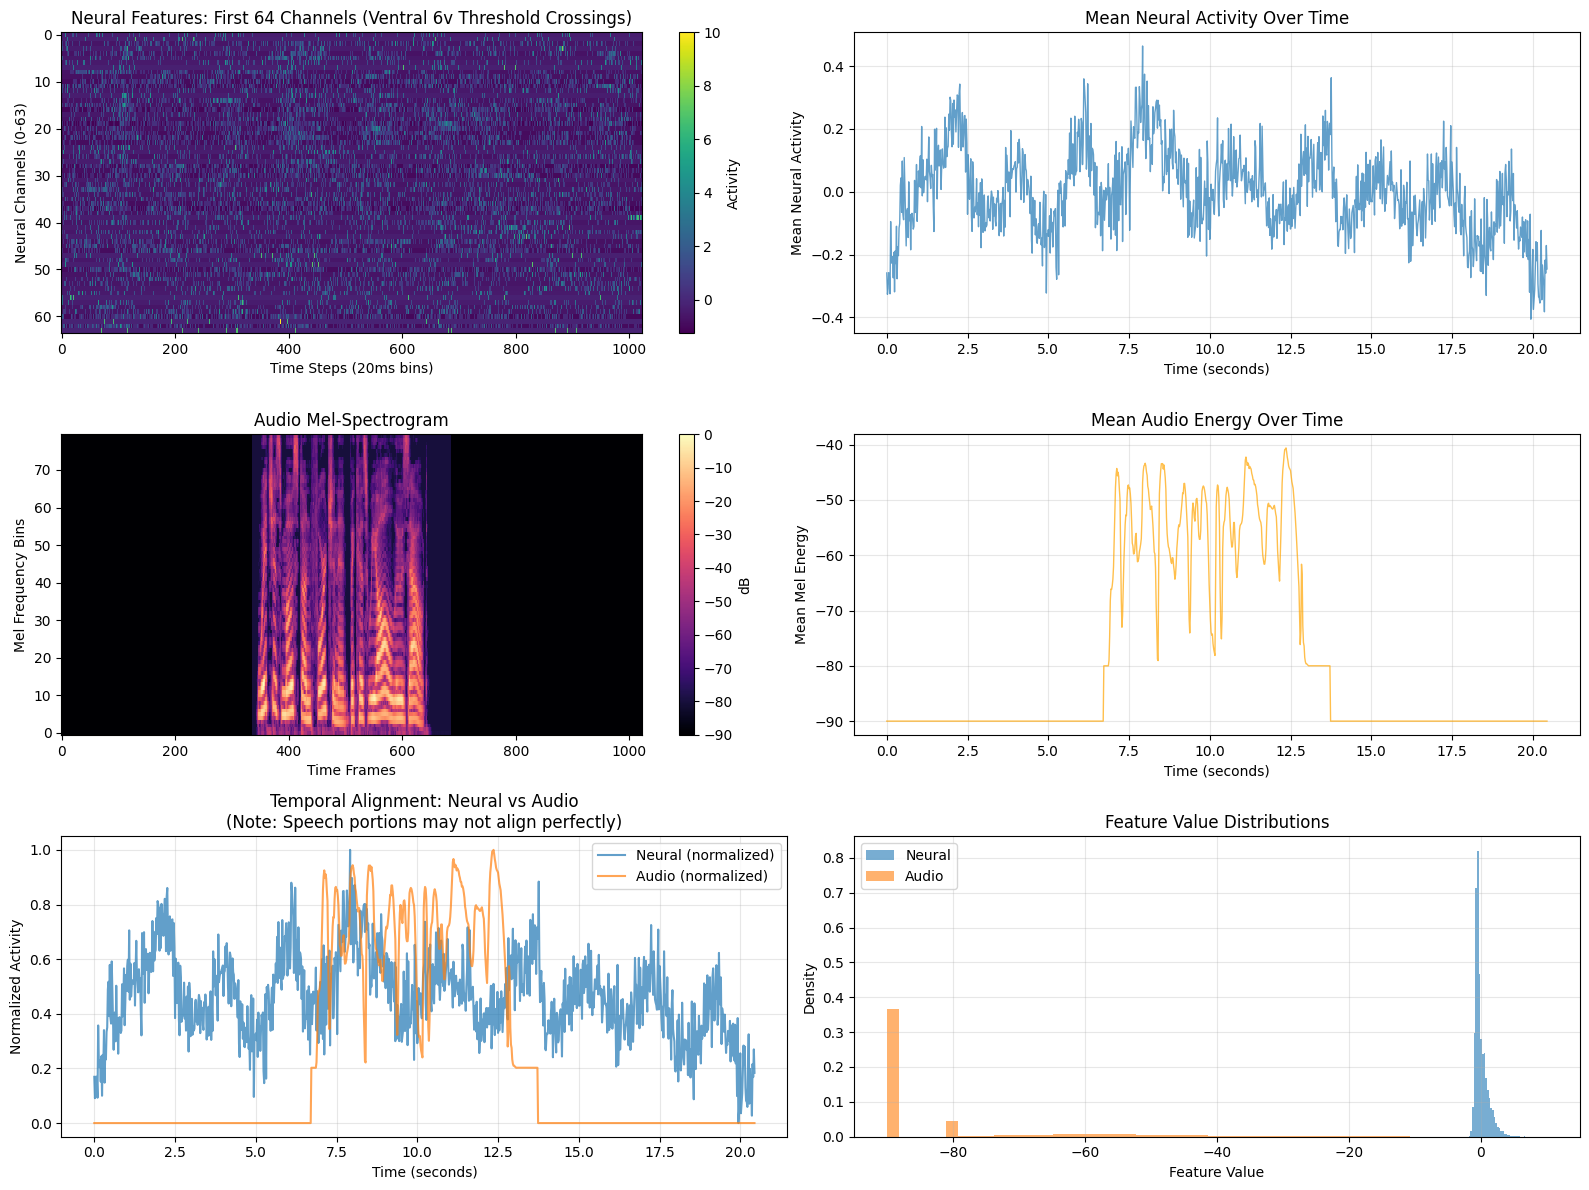


🔊 Audio Sample:
   Path: audio_cache/train_0000.mp3
   Duration: 3.50 seconds
   Sample rate: 16000 Hz
   Playing audio...


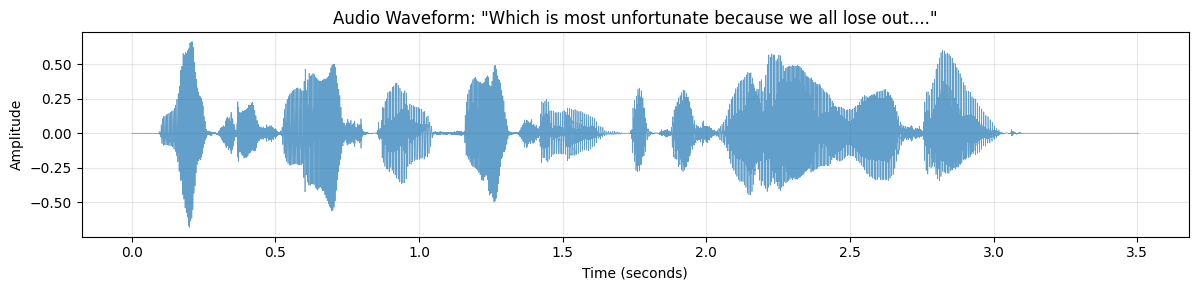


📊 Dataset Statistics:
   Total training samples: 823
   Total validation samples: 132
   Total test samples: 134

   Neural sequence lengths:
      Min: 239 timesteps (4.78s)
      Max: 1735 timesteps (34.70s)
      Mean: 799.6 timesteps (15.99s)
      Median: 778.0 timesteps (15.56s)

   Phoneme sequence lengths:
      Min: 500 phonemes
      Max: 500 phonemes
      Mean: 500.0 phonemes
      Median: 500.0 phonemes

✅ Data verification complete!


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Audio, display, HTML

# Initialize tokenizer for visualization (will be re-initialized later, but needed here)
from data.tokenizer import PhonemeTokenizer
viz_tokenizer = PhonemeTokenizer()

# Select a sample trial for visualization
sample_idx = 0
if len(train_neural) > 0:
    sample_neural = train_neural[sample_idx]
    sample_audio_feat = train_audio_features[sample_idx] if len(train_audio_features) > sample_idx else None
    sample_text = train_texts[sample_idx]
    sample_phonemes = train_phonemes[sample_idx]
    sample_audio_path = train_audio_paths[sample_idx] if len(train_audio_paths) > sample_idx else None
    
    print("=" * 70)
    print("DATA VERIFICATION & VISUALIZATION")
    print("=" * 70)
    
    # 1. Text and phoneme information
    print(f"\nSample Trial #{sample_idx + 1}:")
    print(f"Text: '{sample_text}'")
    print(f"Text length: {len(sample_text)} characters")
    print(f"Phoneme sequence length: {len(sample_phonemes) if sample_phonemes is not None else 0}")
    if sample_phonemes is not None and len(sample_phonemes) > 0:
        phoneme_list = sample_phonemes[:20].tolist() if hasattr(sample_phonemes, 'tolist') else list(sample_phonemes[:20])
        sample_phoneme_str = viz_tokenizer.decode(phoneme_list)
        print(f"First 20 phonemes: {sample_phoneme_str}")
    
    # 2. Neural features visualization
    print(f"\nNeural Features:")
    print(f"Shape: {sample_neural.shape} (time_steps × features)")
    print(f"Time steps: {sample_neural.shape[0]} (~{sample_neural.shape[0] * 20 / 1000:.2f} seconds)")
    print(f"Feature channels: {sample_neural.shape[1]}")
    print(f"Value range: [{sample_neural.min():.2f}, {sample_neural.max():.2f}]")
    print(f"Mean: {sample_neural.mean():.2f}, Std: {sample_neural.std():.2f}")
    
    # 3. Audio features visualization
    if sample_audio_feat is not None:
        # Calculate actual audio duration (before padding)
        if sample_audio_path and os.path.exists(sample_audio_path):
            try:
                y_orig, sr_orig = librosa.load(sample_audio_path, sr=CONFIG['sample_rate'])
                actual_audio_duration = len(y_orig) / sr_orig
                neural_duration = sample_neural.shape[0] * 20 / 1000
                padding_ratio = (neural_duration - actual_audio_duration) / neural_duration * 100
            except:
                actual_audio_duration = None
                padding_ratio = None
        else:
            actual_audio_duration = None
            padding_ratio = None
        
        print(f"\nAudio Features:")
        print(f"Shape: {sample_audio_feat.shape} (time_frames × mel_bins)")
        print(f"Time frames: {sample_audio_feat.shape[0]} (aligned with neural)")
        print(f"Mel bins: {sample_audio_feat.shape[1]}")
        print(f"Value range: [{sample_audio_feat.min():.2f}, {sample_audio_feat.max():.2f}]")
        if actual_audio_duration:
            print(f"Actual audio duration: {actual_audio_duration:.2f}s (neural: {neural_duration:.2f}s)")
            print(f"Silence padding: ~{padding_ratio:.1f}% of total duration")
        print(f"Temporal alignment: {'Length matched' if sample_neural.shape[0] == sample_audio_feat.shape[0] else 'Length mismatch'}")
        print(f"Note: Speech portions may not align perfectly (see visualization)")
    
    # 4. Create visualizations
    fig = plt.figure(figsize=(16, 12))
    
    # Plot 1: Neural features heatmap (subset of channels)
    ax1 = plt.subplot(3, 2, 1)
    neural_subset = sample_neural[:, :64].T  # First 64 channels (ventral 6v threshold crossings)
    im1 = ax1.imshow(neural_subset, aspect='auto', cmap='viridis', interpolation='nearest')
    ax1.set_xlabel('Time Steps (20ms bins)')
    ax1.set_ylabel('Neural Channels (0-63)')
    ax1.set_title('Neural Features: First 64 Channels (Ventral 6v Threshold Crossings)')
    plt.colorbar(im1, ax=ax1, label='Activity')
    
    # Plot 2: Neural features - mean activity over time
    ax2 = plt.subplot(3, 2, 2)
    neural_mean = sample_neural.mean(axis=1)
    time_axis = np.arange(len(neural_mean)) * 20 / 1000  # Convert to seconds
    ax2.plot(time_axis, neural_mean, linewidth=1, alpha=0.7)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Mean Neural Activity')
    ax2.set_title('Mean Neural Activity Over Time')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Audio mel-spectrogram
    if sample_audio_feat is not None:
        ax3 = plt.subplot(3, 2, 3)
        im3 = ax3.imshow(sample_audio_feat.T, aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
        ax3.set_xlabel('Time Frames')
        ax3.set_ylabel('Mel Frequency Bins')
        ax3.set_title('Audio Mel-Spectrogram')
        plt.colorbar(im3, ax=ax3, label='dB')
    
    # Plot 4: Audio features - mean energy over time
    if sample_audio_feat is not None:
        ax4 = plt.subplot(3, 2, 4)
        audio_mean = sample_audio_feat.mean(axis=1)
        time_axis_audio = np.arange(len(audio_mean)) * 20 / 1000  # Convert to seconds (aligned with neural)
        ax4.plot(time_axis_audio, audio_mean, linewidth=1, alpha=0.7, color='orange')
        ax4.set_xlabel('Time (seconds)')
        ax4.set_ylabel('Mean Mel Energy')
        ax4.set_title('Mean Audio Energy Over Time')
        ax4.grid(True, alpha=0.3)
    
    # Plot 5: Temporal alignment comparison
    ax5 = plt.subplot(3, 2, 5)
    if sample_audio_feat is not None:
        # Normalize for comparison
        neural_norm = (neural_mean - neural_mean.min()) / (neural_mean.max() - neural_mean.min() + 1e-8)
        audio_norm = (audio_mean - audio_mean.min()) / (audio_mean.max() - audio_mean.min() + 1e-8)
        
        ax5.plot(time_axis, neural_norm, label='Neural (normalized)', alpha=0.7, linewidth=1.5)
        ax5.plot(time_axis_audio, audio_norm, label='Audio (normalized)', alpha=0.7, linewidth=1.5)
        ax5.set_xlabel('Time (seconds)')
        ax5.set_ylabel('Normalized Activity')
        ax5.set_title('Temporal Alignment: Neural vs Audio\n(Note: Speech portions may not align perfectly)')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # Add annotation about alignment
        # Detect where audio has actual content (not silence padding)
        audio_threshold = audio_mean.max() * 0.1  # 10% of max as threshold
        audio_active = audio_mean > audio_threshold
        if audio_active.any():
            active_start = np.where(audio_active)[0][0] * 20 / 1000
            active_end = np.where(audio_active)[0][-1] * 20 / 1000
            ax5.axvspan(active_start, active_end, alpha=0.2, color='orange', label='Audio active region')
            ax5.legend()
    
    # Plot 6: Feature distribution
    ax6 = plt.subplot(3, 2, 6)
    ax6.hist(sample_neural.flatten(), bins=50, alpha=0.6, label='Neural', density=True)
    if sample_audio_feat is not None:
        ax6.hist(sample_audio_feat.flatten(), bins=50, alpha=0.6, label='Audio', density=True)
    ax6.set_xlabel('Feature Value')
    ax6.set_ylabel('Density')
    ax6.set_title('Feature Value Distributions')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Play audio sample
    if sample_audio_path and os.path.exists(sample_audio_path):
        print(f"\nAudio Sample:")
        print(f"Path: {sample_audio_path}")
        try:
            # Load and display audio
            y, sr = librosa.load(sample_audio_path, sr=CONFIG['sample_rate'])
            duration = len(y) / sr
            print(f"Duration: {duration:.2f} seconds")
            print(f"Sample rate: {sr} Hz")
            print(f"Playing audio...")
            
            # Display audio player
            display(Audio(sample_audio_path, autoplay=False))
            
            # Also show waveform
            fig_audio, ax_audio = plt.subplots(figsize=(12, 3))
            time_audio = np.arange(len(y)) / sr
            ax_audio.plot(time_audio, y, linewidth=0.5, alpha=0.7)
            ax_audio.set_xlabel('Time (seconds)')
            ax_audio.set_ylabel('Amplitude')
            ax_audio.set_title(f'Audio Waveform: "{sample_text[:50]}..."')
            ax_audio.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error loading audio: {e}")
    else:
        print(f"\nAudio Sample: Not available")
    
    # 6. Summary statistics
    print(f"\nDataset Statistics:")
    print(f"Total training samples: {len(train_neural)}")
    print(f"Total validation samples: {len(val_neural)}")
    print(f"Total test samples: {len(test_neural)}")
    
    if len(train_neural) > 0:
        neural_lengths = [n.shape[0] for n in train_neural]
        print(f"\nNeural sequence lengths:")
        print(f"Min: {min(neural_lengths)} timesteps ({min(neural_lengths) * 20 / 1000:.2f}s)")
        print(f"Max: {max(neural_lengths)} timesteps ({max(neural_lengths) * 20 / 1000:.2f}s)")
        print(f"Mean: {np.mean(neural_lengths):.1f} timesteps ({np.mean(neural_lengths) * 20 / 1000:.2f}s)")
        print(f"Median: {np.median(neural_lengths):.1f} timesteps ({np.median(neural_lengths) * 20 / 1000:.2f}s)")
    
    if len(train_phonemes) > 0 and train_phonemes[0] is not None:
        phoneme_lengths = [len(p) for p in train_phonemes if p is not None]
        if phoneme_lengths:
            print(f"\nPhoneme sequence lengths:")
            print(f"Min: {min(phoneme_lengths)} phonemes")
            print(f"Max: {max(phoneme_lengths)} phonemes")
            print(f"Mean: {np.mean(phoneme_lengths):.1f} phonemes")
            print(f"Median: {np.median(phoneme_lengths):.1f} phonemes")
    
    print(f"\nData verification complete!")
    print("=" * 70)
else:
    print("No training data available for visualization")


## 5.2 Wav2Vec2Phoneme Feature Extraction

Extract pre-trained Wav2Vec2Phoneme features from audio.

**Rationale**:
- Wav2Vec2Phoneme is pre-trained for phoneme recognition
- Provides phoneme-aligned representations
- May capture better acoustic-phonetic information than mel-spectrograms


In [123]:
# Load Wav2Vec2Phoneme model and processor
# Note: We use Wav2Vec2Model (base model) for feature extraction
# The phoneme-specific part is in the tokenizer, but for features we just need the encoder
print("Loading Wav2Vec2Phoneme model...")
wav2vec2_phoneme_model_name = "Bluecast/wav2vec2-Phoneme"
try:
    wav2vec2_processor = Wav2Vec2Processor.from_pretrained(wav2vec2_phoneme_model_name)
    wav2vec2_model = Wav2Vec2Model.from_pretrained(wav2vec2_phoneme_model_name)
    wav2vec2_model.eval()  # Set to eval mode for feature extraction
    wav2vec2_model = wav2vec2_model.to(CONFIG['device'])
    print(f"Wav2Vec2Phoneme model loaded: {wav2vec2_phoneme_model_name} (device: {CONFIG['device']})")
except Exception as e:
    print(f"Error loading model {wav2vec2_phoneme_model_name}: {e}")
    print("Trying fallback model...")
    # Fallback to Facebook model
    wav2vec2_phoneme_model_name = "facebook/wav2vec2-lv-60-espeak-cv-ft"
    wav2vec2_processor = Wav2Vec2Processor.from_pretrained(wav2vec2_phoneme_model_name)
    wav2vec2_model = Wav2Vec2Model.from_pretrained(wav2vec2_phoneme_model_name)
    wav2vec2_model.eval()
    wav2vec2_model = wav2vec2_model.to(CONFIG['device'])
    print(f"Loaded fallback model: {wav2vec2_phoneme_model_name}")

def extract_wav2vec2_features(audio_path, target_length=None, alignment_strategy='center'):
    """
    Extract Wav2Vec2Phoneme features from audio file.
    
    Args:
        audio_path: Path to audio file
        target_length: Target length in frames (neural timesteps)
        alignment_strategy: How to align audio to neural length ('start', 'center', 'end')
    """
    if audio_path is None or not os.path.exists(audio_path):
        return None
    
    try:
        # Load audio at 16kHz (Wav2Vec2Phoneme requirement)
        y, sr = librosa.load(audio_path, sr=16000)
        
        # Process audio
        inputs = wav2vec2_processor(y, sampling_rate=16000, return_tensors="pt", padding=True)
        
        # Extract features
        with torch.no_grad():
            # Move to device
            input_values = inputs.input_values.to(CONFIG['device'])
            
            # Get hidden states (before phoneme prediction)
            outputs = wav2vec2_model(input_values, output_hidden_states=True)
            # Use last hidden state: (B, T, hidden_dim)
            features = outputs.hidden_states[-1].squeeze(0).cpu().numpy()  # (T, hidden_dim)
        
        # Align to target length (neural timesteps) if provided
        if target_length is not None:
            audio_length = features.shape[0]
            
            if audio_length < target_length:
                # Need to pad
                padding_needed = target_length - audio_length
                hidden_dim = features.shape[1]
                
                # Create zero padding (silence)
                silence_padding = np.zeros((padding_needed, hidden_dim))
                
                if alignment_strategy == 'start':
                    features = np.vstack([features, silence_padding])
                elif alignment_strategy == 'center':
                    pad_before = padding_needed // 2
                    pad_after = padding_needed - pad_before
                    features = np.vstack([
                        np.zeros((pad_before, hidden_dim)),
                        features,
                        np.zeros((pad_after, hidden_dim))
                    ])
                elif alignment_strategy == 'end':
                    features = np.vstack([silence_padding, features])
                else:
                    features = np.vstack([features, silence_padding])
                    
            elif audio_length > target_length:
                # Need to truncate
                if alignment_strategy == 'start':
                    features = features[:target_length]
                elif alignment_strategy == 'center':
                    start_idx = (audio_length - target_length) // 2
                    features = features[start_idx:start_idx + target_length]
                elif alignment_strategy == 'end':
                    features = features[-target_length:]
                else:
                    features = features[:target_length]
        
        return features
    
    except Exception as e:
        return None

def extract_all_wav2vec2_features(neural_features, audio_paths, alignment_strategy='center'):
    """Extract Wav2Vec2Phoneme features for all trials."""
    audio_features = []
    
    for neural, audio_path in tqdm(zip(neural_features, audio_paths), desc="Extracting Wav2Vec2Phoneme features", total=len(neural_features)):
        target_length = neural.shape[0]  # Align to neural timesteps
        audio_feat = extract_wav2vec2_features(audio_path, target_length=target_length, 
                                               alignment_strategy=alignment_strategy)
        audio_features.append(audio_feat)
    
    return audio_features

# Extract Wav2Vec2Phoneme features
print("Extracting Wav2Vec2Phoneme features...")
train_wav2vec2_features = extract_all_wav2vec2_features(train_neural, train_audio_paths, alignment_strategy=ALIGNMENT_STRATEGY)
val_wav2vec2_features = extract_all_wav2vec2_features(val_neural, val_audio_paths, alignment_strategy=ALIGNMENT_STRATEGY)
test_wav2vec2_features = extract_all_wav2vec2_features(test_neural, test_audio_paths, alignment_strategy=ALIGNMENT_STRATEGY)

# Filter valid pairs (preserve phoneme labels)
train_neural_w2v, train_wav2vec2_features, train_texts_w2v, train_phonemes_w2v = filter_valid_pairs(
    train_neural, train_wav2vec2_features, train_texts, train_phonemes)
val_neural_w2v, val_wav2vec2_features, val_texts_w2v, val_phonemes_w2v = filter_valid_pairs(
    val_neural, val_wav2vec2_features, val_texts, val_phonemes)
test_neural_w2v, test_wav2vec2_features, test_texts_w2v, test_phonemes_w2v = filter_valid_pairs(
    test_neural, test_wav2vec2_features, test_texts, test_phonemes)

print(f"Wav2Vec2Phoneme feature extraction: Train={len(train_neural_w2v)}, Val={len(val_neural_w2v)}, Test={len(test_neural_w2v)}")

if len(train_wav2vec2_features) > 0 and train_wav2vec2_features[0] is not None:
    print(f"Wav2Vec2Phoneme feature dim: {train_wav2vec2_features[0].shape[1]}")


Loading Wav2Vec2Phoneme model...
Wav2Vec2Phoneme model loaded: Bluecast/wav2vec2-Phoneme (device: mps)
Extracting Wav2Vec2Phoneme features...


Extracting Wav2Vec2Phoneme features:   0%|          | 0/134 [00:00<?, ?it/s]

Wav2Vec2Phoneme feature extraction: Train=822, Val=132, Test=0
Wav2Vec2Phoneme feature dim: 1024


In [124]:
def extract_audio_features(audio_path, target_length=None, alignment_strategy='center'):
    """
    Extract mel-spectrogram features from audio file.
    
    Args:
        audio_path: Path to audio file
        target_length: Target length in frames (neural timesteps)
        alignment_strategy: How to align audio to neural length
            - 'start': Put audio at beginning, pad at end (default)
            - 'center': Center audio, pad equally on both sides
            - 'end': Put audio at end, pad at beginning
    """
    if audio_path is None or not os.path.exists(audio_path):
        return None
    
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=CONFIG['sample_rate'])
        
        # Extract mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_mels=CONFIG['audio_feature_dim'],
            hop_length=CONFIG['audio_hop_length'],
            n_fft=512,
            fmin=0,
            fmax=sr//2
        )
        
        # Convert to log scale (dB)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Transpose to (time_frames, n_mels)
        mel_spec_db = mel_spec_db.T
        
        # Align to target length (neural timesteps) if provided
        if target_length is not None:
            audio_length = mel_spec_db.shape[0]
            
            if audio_length < target_length:
                # Need to pad
                padding_needed = target_length - audio_length
                
                # Create silence padding (low energy, matching background)
                silence_padding = np.full((padding_needed, CONFIG['audio_feature_dim']), 
                                         mel_spec_db.min() - 10)  # Silence ~10dB below min
                
                if alignment_strategy == 'start':
                    # Put audio at start, pad at end (original behavior)
                    mel_spec_db = np.vstack([mel_spec_db, silence_padding])
                elif alignment_strategy == 'center':
                    # Center audio, pad equally on both sides
                    pad_before = padding_needed // 2
                    pad_after = padding_needed - pad_before
                    mel_spec_db = np.vstack([
                        np.full((pad_before, CONFIG['audio_feature_dim']), mel_spec_db.min() - 10),
                        mel_spec_db,
                        np.full((pad_after, CONFIG['audio_feature_dim']), mel_spec_db.min() - 10)
                    ])
                elif alignment_strategy == 'end':
                    # Put audio at end, pad at beginning
                    mel_spec_db = np.vstack([silence_padding, mel_spec_db])
                else:
                    # Default to start
                    mel_spec_db = np.vstack([mel_spec_db, silence_padding])
                    
            elif audio_length > target_length:
                # Need to truncate
                if alignment_strategy == 'start':
                    mel_spec_db = mel_spec_db[:target_length]
                elif alignment_strategy == 'center':
                    start_idx = (audio_length - target_length) // 2
                    mel_spec_db = mel_spec_db[start_idx:start_idx + target_length]
                elif alignment_strategy == 'end':
                    mel_spec_db = mel_spec_db[-target_length:]
                else:
                    mel_spec_db = mel_spec_db[:target_length]
        
        return mel_spec_db
    
    except Exception as e:
        return None

def extract_all_audio_features(neural_features, audio_paths, alignment_strategy='center'):
    """
    Extract audio features for all trials, aligned to neural timesteps.
    
    Args:
        neural_features: List of neural feature arrays
        audio_paths: List of audio file paths
        alignment_strategy: How to align audio ('start', 'center', 'end')
    """
    audio_features = []
    
    for neural, audio_path in tqdm(zip(neural_features, audio_paths), desc="Extracting audio features", total=len(neural_features)):
        target_length = neural.shape[0]  # Align to neural timesteps
        audio_feat = extract_audio_features(audio_path, target_length=target_length, 
                                           alignment_strategy=alignment_strategy)
        audio_features.append(audio_feat)
    
    return audio_features

# Extract audio features with center alignment (speech in middle, silence on sides)
ALIGNMENT_STRATEGY = 'center'
print(f"Extracting audio features (alignment: {ALIGNMENT_STRATEGY})...")

train_audio_features = extract_all_audio_features(train_neural, train_audio_paths, alignment_strategy=ALIGNMENT_STRATEGY)
val_audio_features = extract_all_audio_features(val_neural, val_audio_paths, alignment_strategy=ALIGNMENT_STRATEGY)
test_audio_features = extract_all_audio_features(test_neural, test_audio_paths, alignment_strategy=ALIGNMENT_STRATEGY)

# Filter out None values and preserve phoneme labels
def filter_valid_pairs(neural_list, audio_list, text_list, phoneme_list):
    """Keep only trials where audio extraction succeeded."""
    valid_neural, valid_audio, valid_text, valid_phonemes = [], [], [], []
    for n, a, t, p in zip(neural_list, audio_list, text_list, phoneme_list):
        if a is not None:
            valid_neural.append(n)
            valid_audio.append(a)
            valid_text.append(t)
            valid_phonemes.append(p)
    return valid_neural, valid_audio, valid_text, valid_phonemes

train_neural, train_audio_features, train_texts, train_phonemes = filter_valid_pairs(
    train_neural, train_audio_features, train_texts, train_phonemes)
val_neural, val_audio_features, val_texts, val_phonemes = filter_valid_pairs(
    val_neural, val_audio_features, val_texts, val_phonemes)
test_neural, test_audio_features, test_texts, test_phonemes = filter_valid_pairs(
    test_neural, test_audio_features, test_texts, test_phonemes)

print(f"Audio feature extraction: Train={len(train_neural)}, Val={len(val_neural)}, Test={len(test_neural)}")


Extracting audio features (alignment: center)...


Extracting audio features:   0%|          | 0/134 [00:00<?, ?it/s]

Audio feature extraction: Train=822, Val=132, Test=0


In [125]:
# Add missing dataset classes for Wav2Vec2Phoneme and Combined models

class MultimodalWav2Vec2Dataset(Dataset):
    """Dataset for neural+Wav2Vec2Phoneme multimodal model."""
    
    def __init__(self, neural_features, wav2vec2_features, phoneme_labels, text_labels, tokenizer):
        self.neural_features = neural_features
        self.wav2vec2_features = wav2vec2_features
        self.phoneme_labels = phoneme_labels
        self.text_labels = text_labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.neural_features)
    
    def __getitem__(self, idx):
        neural = torch.tensor(self.neural_features[idx], dtype=torch.float32)
        wav2vec2 = torch.tensor(self.wav2vec2_features[idx], dtype=torch.float32)
        text = self.text_labels[idx]
        if self.phoneme_labels[idx] is not None:
            phonemes = torch.tensor(self.phoneme_labels[idx], dtype=torch.long)
        else:
            phonemes = torch.tensor([], dtype=torch.long)
        return neural, wav2vec2, phonemes, text

class CombinedMultimodalDataset(Dataset):
    """Dataset for neural+mel+Wav2Vec2Phoneme combined multimodal model."""
    
    def __init__(self, neural_features, mel_features, wav2vec2_features, phoneme_labels, text_labels, tokenizer):
        self.neural_features = neural_features
        self.mel_features = mel_features
        self.wav2vec2_features = wav2vec2_features
        self.phoneme_labels = phoneme_labels
        self.text_labels = text_labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.neural_features)
    
    def __getitem__(self, idx):
        neural = torch.tensor(self.neural_features[idx], dtype=torch.float32)
        mel = torch.tensor(self.mel_features[idx], dtype=torch.float32)
        wav2vec2 = torch.tensor(self.wav2vec2_features[idx], dtype=torch.float32)
        text = self.text_labels[idx]
        if self.phoneme_labels[idx] is not None:
            phonemes = torch.tensor(self.phoneme_labels[idx], dtype=torch.long)
        else:
            phonemes = torch.tensor([], dtype=torch.long)
        return neural, mel, wav2vec2, phonemes, text

# Create Wav2Vec2Phoneme datasets (using filtered data that matches Wav2Vec2 features)
multimodal_w2v_train = MultimodalWav2Vec2Dataset(train_neural_w2v, train_wav2vec2_features, train_phonemes_w2v, train_texts_w2v, tokenizer)
multimodal_w2v_val = MultimodalWav2Vec2Dataset(val_neural_w2v, val_wav2vec2_features, val_phonemes_w2v, val_texts_w2v, tokenizer)
multimodal_w2v_test = MultimodalWav2Vec2Dataset(test_neural_w2v, test_wav2vec2_features, test_phonemes_w2v, test_texts_w2v, tokenizer)

# For combined model, we need mel features that match the Wav2Vec2 filtered indices
# Filter mel features to match Wav2Vec2 filtered data
def filter_mel_to_match_w2v(mel_list, w2v_neural_list, original_neural_list):
    """Filter mel features to match indices where Wav2Vec2 features exist."""
    mel_filtered = []
    w2v_idx = 0
    for i, neural in enumerate(original_neural_list):
        if w2v_idx < len(w2v_neural_list) and np.array_equal(neural, w2v_neural_list[w2v_idx]):
            mel_filtered.append(mel_list[i])
            w2v_idx += 1
    return mel_filtered

# Filter mel features to match Wav2Vec2 filtered data
train_mel_filtered = filter_mel_to_match_w2v(train_audio_features, train_neural_w2v, train_neural)
val_mel_filtered = filter_mel_to_match_w2v(val_audio_features, val_neural_w2v, val_neural)
test_mel_filtered = filter_mel_to_match_w2v(test_audio_features, test_neural_w2v, test_neural)

# Combined datasets (neural + mel + wav2vec2)
multimodal_combined_train = CombinedMultimodalDataset(train_neural_w2v, train_mel_filtered, train_wav2vec2_features, train_phonemes_w2v, train_texts_w2v, tokenizer)
multimodal_combined_val = CombinedMultimodalDataset(val_neural_w2v, val_mel_filtered, val_wav2vec2_features, val_phonemes_w2v, val_texts_w2v, tokenizer)
multimodal_combined_test = CombinedMultimodalDataset(test_neural_w2v, test_mel_filtered, test_wav2vec2_features, test_phonemes_w2v, test_texts_w2v, tokenizer)

print(f"Additional datasets created:")
print(f"  Multimodal (Wav2Vec2) train={len(multimodal_w2v_train)}, val={len(multimodal_w2v_val)}, test={len(multimodal_w2v_test)}")
print(f"  Combined train={len(multimodal_combined_train)}, val={len(multimodal_combined_val)}, test={len(multimodal_combined_test)}")


Additional datasets created:
  Multimodal (Wav2Vec2) train=822, val=132, test=0
  Combined train=822, val=132, test=0


## 6. Dataset Classes

Create PyTorch datasets for baseline (neural-only) and multimodal (neural+audio) models.


In [126]:
class BaselineDataset(Dataset):
    """Dataset for neural-only baseline model."""
    
    def __init__(self, neural_features, phoneme_labels, text_labels, tokenizer):
        self.neural_features = neural_features
        self.phoneme_labels = phoneme_labels  # Use phoneme labels from HDF5
        self.text_labels = text_labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.neural_features)
    
    def __getitem__(self, idx):
        neural = torch.tensor(self.neural_features[idx], dtype=torch.float32)
        text = self.text_labels[idx]
        # Use phoneme labels directly from HDF5 (already encoded)
        if self.phoneme_labels[idx] is not None:
            phonemes = torch.tensor(self.phoneme_labels[idx], dtype=torch.long)
        else:
            # Fallback: empty tensor (shouldn't happen for train/val)
            phonemes = torch.tensor([], dtype=torch.long)
        return neural, phonemes, text

class MultimodalDataset(Dataset):
    """Dataset for neural+audio multimodal model."""
    
    def __init__(self, neural_features, audio_features, phoneme_labels, text_labels, tokenizer):
        self.neural_features = neural_features
        self.audio_features = audio_features
        self.phoneme_labels = phoneme_labels  # Use phoneme labels from HDF5
        self.text_labels = text_labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.neural_features)
    
    def __getitem__(self, idx):
        neural = torch.tensor(self.neural_features[idx], dtype=torch.float32)
        audio = torch.tensor(self.audio_features[idx], dtype=torch.float32)
        text = self.text_labels[idx]
        # Use phoneme labels directly from HDF5 (already encoded)
        if self.phoneme_labels[idx] is not None:
            phonemes = torch.tensor(self.phoneme_labels[idx], dtype=torch.long)
        else:
            # Fallback: empty tensor (shouldn't happen for train/val)
            phonemes = torch.tensor([], dtype=torch.long)
        return neural, audio, phonemes, text

# Initialize tokenizer (for decoding predictions)
tokenizer = PhonemeTokenizer()

# Create datasets
baseline_train = BaselineDataset(train_neural, train_phonemes, train_texts, tokenizer)
baseline_val = BaselineDataset(val_neural, val_phonemes, val_texts, tokenizer)
baseline_test = BaselineDataset(test_neural, test_phonemes, test_texts, tokenizer)

multimodal_train = MultimodalDataset(train_neural, train_audio_features, train_phonemes, train_texts, tokenizer)
multimodal_val = MultimodalDataset(val_neural, val_audio_features, val_phonemes, val_texts, tokenizer)
multimodal_test = MultimodalDataset(test_neural, test_audio_features, test_phonemes, test_texts, tokenizer)

print(f"Datasets created: Baseline train={len(baseline_train)}, Multimodal train={len(multimodal_train)}")


Datasets created: Baseline train=822, Multimodal train=822


## 7. Model Architectures

### 7.1 Baseline Model (Neural-Only)

Standard LSTM encoder for neural features → phoneme prediction.


### 7.3 Wav2Vec2Phoneme Model (Neural + Wav2Vec2Phoneme)

Similar architecture to Mel model but uses Wav2Vec2Phoneme features instead.


In [127]:
class Wav2Vec2MultimodalModel(nn.Module):
    """Multimodal model with neural + Wav2Vec2Phoneme features."""
    
    def __init__(self, neural_input_size=512, wav2vec2_input_size=768, hidden_size=256, num_layers=2, num_phonemes=41, dropout=0.2):
        super().__init__()
        
        # Neural encoder
        self.neural_adapter = nn.Linear(neural_input_size, hidden_size)
        self.neural_lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        
        # Wav2Vec2Phoneme encoder
        self.wav2vec2_adapter = nn.Linear(wav2vec2_input_size, hidden_size)
        self.wav2vec2_lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        
        # Cross-modal attention
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        
        # Feature fusion
        self.fusion = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Output projection
        self.output_proj = nn.Linear(hidden_size * 2, num_phonemes)
        
    def forward(self, neural, wav2vec2):
        # neural: (B, T, 512), wav2vec2: (B, T, 768)
        
        # Encode neural features
        neural_emb = self.neural_adapter(neural)
        neural_out, _ = self.neural_lstm(neural_emb)
        
        # Encode Wav2Vec2Phoneme features
        wav2vec2_emb = self.wav2vec2_adapter(wav2vec2)
        wav2vec2_out, _ = self.wav2vec2_lstm(wav2vec2_emb)
        
        # Cross-modal attention: neural queries wav2vec2
        attended_neural, _ = self.cross_attention(
            query=neural_out,
            key=wav2vec2_out,
            value=wav2vec2_out
        )
        
        # Fuse features
        fused = torch.cat([neural_out, attended_neural], dim=-1)
        fused = self.fusion(fused)
        
        # Output projection
        logits = self.output_proj(fused)
        return F.log_softmax(logits, dim=-1)

print("Wav2Vec2Phoneme multimodal model defined")


Wav2Vec2Phoneme multimodal model defined


? 

In [128]:
class CombinedMultimodalModel(nn.Module):
    """Multimodal model with neural + mel + Wav2Vec2Phoneme features."""
    
    def __init__(self, neural_input_size=512, mel_input_size=80, wav2vec2_input_size=768, 
                 hidden_size=256, num_layers=2, num_phonemes=41, dropout=0.2):
        super().__init__()
        
        # Neural encoder
        self.neural_adapter = nn.Linear(neural_input_size, hidden_size)
        self.neural_lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        
        # Mel-spectrogram encoder
        self.mel_adapter = nn.Linear(mel_input_size, hidden_size)
        self.mel_lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        
        # Wav2Vec2Phoneme encoder
        self.wav2vec2_adapter = nn.Linear(wav2vec2_input_size, hidden_size)
        self.wav2vec2_lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        
        # Cross-modal attention: neural queries mel
        self.attention_neural_mel = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        
        # Cross-modal attention: neural queries wav2vec2
        self.attention_neural_w2v = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        
        # Feature fusion (neural + attended_mel + attended_w2v)
        self.fusion = nn.Sequential(
            nn.Linear(hidden_size * 6, hidden_size * 2),  # neural + mel + w2v
            nn.LayerNorm(hidden_size * 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Output projection
        self.output_proj = nn.Linear(hidden_size * 2, num_phonemes)
        
    def forward(self, neural, mel, wav2vec2):
        # neural: (B, T, 512), mel: (B, T, 80), wav2vec2: (B, T, 768)
        
        # Encode neural features
        neural_emb = self.neural_adapter(neural)
        neural_out, _ = self.neural_lstm(neural_emb)
        
        # Encode mel features
        mel_emb = self.mel_adapter(mel)
        mel_out, _ = self.mel_lstm(mel_emb)
        
        # Encode Wav2Vec2Phoneme features
        wav2vec2_emb = self.wav2vec2_adapter(wav2vec2)
        wav2vec2_out, _ = self.wav2vec2_lstm(wav2vec2_emb)
        
        # Cross-modal attention: neural queries mel
        attended_mel, _ = self.attention_neural_mel(
            query=neural_out,
            key=mel_out,
            value=mel_out
        )
        
        # Cross-modal attention: neural queries wav2vec2
        attended_w2v, _ = self.attention_neural_w2v(
            query=neural_out,
            key=wav2vec2_out,
            value=wav2vec2_out
        )
        
        # Fuse all features
        fused = torch.cat([neural_out, attended_mel, attended_w2v], dim=-1)
        fused = self.fusion(fused)
        
        # Output projection
        logits = self.output_proj(fused)
        return F.log_softmax(logits, dim=-1)

print("Combined multimodal model defined")


Combined multimodal model defined


In [129]:
class BaselineModel(nn.Module):
    """Baseline neural-only LSTM model."""
    
    def __init__(self, neural_input_size=512, hidden_size=256, num_layers=2, num_phonemes=41, dropout=0.2):
        super().__init__()
        
        # Input adapter
        self.input_adapter = nn.Linear(neural_input_size, hidden_size)
        
        # LSTM encoder
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        
        # Output projection
        self.output_proj = nn.Linear(hidden_size * 2, num_phonemes)  # *2 for bidirectional
        
    def forward(self, x):
        # x: (B, T, 512)
        x = self.input_adapter(x)  # (B, T, hidden_size)
        lstm_out, _ = self.lstm(x)  # (B, T, hidden_size*2)
        logits = self.output_proj(lstm_out)  # (B, T, num_phonemes)
        return F.log_softmax(logits, dim=-1)  # (B, T, num_phonemes)

print("Baseline model defined")


Baseline model defined


### 7.2 Multimodal Model (Neural + Audio)

**Architecture**:
- Separate encoders for neural and audio features
- Cross-modal attention for feature fusion
- Joint representation → phoneme prediction

**Rationale**:
- Cross-modal attention allows the model to learn which audio features are relevant for each neural timestep
- Preserves temporal alignment between modalities
- Enables the model to leverage complementary information


In [130]:
class MultimodalModel(nn.Module):
    """Multimodal model with neural + audio features."""
    
    def __init__(self, neural_input_size=512, audio_input_size=80, hidden_size=256, num_layers=2, num_phonemes=41, dropout=0.2):
        super().__init__()
        
        # Neural encoder
        self.neural_adapter = nn.Linear(neural_input_size, hidden_size)
        self.neural_lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        
        # Audio encoder
        self.audio_adapter = nn.Linear(audio_input_size, hidden_size)
        self.audio_lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        
        # Cross-modal attention
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,  # bidirectional
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        
        # Feature fusion
        self.fusion = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size * 2),  # neural + audio + attention
            nn.LayerNorm(hidden_size * 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Output projection
        self.output_proj = nn.Linear(hidden_size * 2, num_phonemes)
        
    def forward(self, neural, audio):
        # neural: (B, T, 512), audio: (B, T, 80)
        
        # Encode neural features
        neural_emb = self.neural_adapter(neural)  # (B, T, hidden_size)
        neural_out, _ = self.neural_lstm(neural_emb)  # (B, T, hidden_size*2)
        
        # Encode audio features
        audio_emb = self.audio_adapter(audio)  # (B, T, hidden_size)
        audio_out, _ = self.audio_lstm(audio_emb)  # (B, T, hidden_size*2)
        
        # Cross-modal attention: neural queries audio
        attended_neural, _ = self.cross_attention(
            query=neural_out,
            key=audio_out,
            value=audio_out
        )  # (B, T, hidden_size*2)
        
        # Fuse features
        fused = torch.cat([neural_out, attended_neural], dim=-1)  # (B, T, hidden_size*4)
        fused = self.fusion(fused)  # (B, T, hidden_size*2)
        
        # Output projection
        logits = self.output_proj(fused)  # (B, T, num_phonemes)
        return F.log_softmax(logits, dim=-1)  # (B, T, num_phonemes)

print("Multimodal model defined")


Multimodal model defined


## 8. Training Functions

Training loop with CTC loss for both models.


In [131]:
def collate_fn_baseline(batch):
    """Collate function for baseline model."""
    neurals, phonemes, texts = zip(*batch)
    
    # Pad neural features
    neural_padded = torch.nn.utils.rnn.pad_sequence(neurals, batch_first=True, padding_value=0.0)
    
    # Pad phonemes
    phoneme_padded = torch.nn.utils.rnn.pad_sequence(phonemes, batch_first=True, padding_value=0)
    
    # Get lengths
    neural_lengths = torch.tensor([len(n) for n in neurals], dtype=torch.long)
    phoneme_lengths = torch.tensor([len(p) for p in phonemes], dtype=torch.long)
    
    return neural_padded, phoneme_padded, neural_lengths, phoneme_lengths, texts

def collate_fn_multimodal(batch):
    """Collate function for multimodal model."""
    neurals, audios, phonemes, texts = zip(*batch)
    
    # Pad neural and audio features
    neural_padded = torch.nn.utils.rnn.pad_sequence(neurals, batch_first=True, padding_value=0.0)
    audio_padded = torch.nn.utils.rnn.pad_sequence(audios, batch_first=True, padding_value=0.0)
    
    # Pad phonemes
    phoneme_padded = torch.nn.utils.rnn.pad_sequence(phonemes, batch_first=True, padding_value=0)
    
    # Get lengths
    neural_lengths = torch.tensor([len(n) for n in neurals], dtype=torch.long)
    phoneme_lengths = torch.tensor([len(p) for p in phonemes], dtype=torch.long)
    
    return neural_padded, audio_padded, phoneme_padded, neural_lengths, phoneme_lengths, texts

def collate_fn_wav2vec2(batch):
    """Collate function for Wav2Vec2Phoneme multimodal model."""
    neurals, wav2vec2s, phonemes, texts = zip(*batch)
    
    # Pad neural and Wav2Vec2Phoneme features
    neural_padded = torch.nn.utils.rnn.pad_sequence(neurals, batch_first=True, padding_value=0.0)
    wav2vec2_padded = torch.nn.utils.rnn.pad_sequence(wav2vec2s, batch_first=True, padding_value=0.0)
    
    # Pad phonemes
    phoneme_padded = torch.nn.utils.rnn.pad_sequence(phonemes, batch_first=True, padding_value=0)
    
    # Get lengths
    neural_lengths = torch.tensor([len(n) for n in neurals], dtype=torch.long)
    phoneme_lengths = torch.tensor([len(p) for p in phonemes], dtype=torch.long)
    
    return neural_padded, wav2vec2_padded, phoneme_padded, neural_lengths, phoneme_lengths, texts

def collate_fn_combined(batch):
    """Collate function for combined multimodal model (neural + mel + wav2vec2)."""
    neurals, mels, wav2vec2s, phonemes, texts = zip(*batch)
    
    # Pad neural, mel, and Wav2Vec2Phoneme features
    neural_padded = torch.nn.utils.rnn.pad_sequence(neurals, batch_first=True, padding_value=0.0)
    mel_padded = torch.nn.utils.rnn.pad_sequence(mels, batch_first=True, padding_value=0.0)
    wav2vec2_padded = torch.nn.utils.rnn.pad_sequence(wav2vec2s, batch_first=True, padding_value=0.0)
    
    # Pad phonemes
    phoneme_padded = torch.nn.utils.rnn.pad_sequence(phonemes, batch_first=True, padding_value=0)
    
    # Get lengths
    neural_lengths = torch.tensor([len(n) for n in neurals], dtype=torch.long)
    phoneme_lengths = torch.tensor([len(p) for p in phonemes], dtype=torch.long)
    
    return neural_padded, mel_padded, wav2vec2_padded, phoneme_padded, neural_lengths, phoneme_lengths, texts

def train_epoch(model, dataloader, criterion, optimizer, device, is_multimodal=False, model_type=None):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    
    # CTC loss is not supported on MPS, so we'll compute it on CPU
    # Forward/backward passes still benefit from GPU acceleration
    ctc_device = 'cpu' if device == 'mps' else device
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        # Handle different model types
        if model_type == 'wav2vec2':
            neural, wav2vec2, phonemes, neural_lengths, phoneme_lengths, _ = batch
            neural = neural.to(device)
            wav2vec2 = wav2vec2.to(device)
            phonemes = phonemes.to(ctc_device)
            neural_lengths = neural_lengths.to(ctc_device)
            phoneme_lengths = phoneme_lengths.to(ctc_device)
            log_probs = model(neural, wav2vec2)
        elif model_type == 'combined':
            neural, mel, wav2vec2, phonemes, neural_lengths, phoneme_lengths, _ = batch
            neural = neural.to(device)
            mel = mel.to(device)
            wav2vec2 = wav2vec2.to(device)
            phonemes = phonemes.to(ctc_device)
            neural_lengths = neural_lengths.to(ctc_device)
            phoneme_lengths = phoneme_lengths.to(ctc_device)
            log_probs = model(neural, mel, wav2vec2)
        elif is_multimodal:
            neural, audio, phonemes, neural_lengths, phoneme_lengths, _ = batch
            neural = neural.to(device)
            audio = audio.to(device)
            phonemes = phonemes.to(ctc_device)  # CTC computation on CPU for MPS
            neural_lengths = neural_lengths.to(ctc_device)
            phoneme_lengths = phoneme_lengths.to(ctc_device)
            
            # Forward pass (on GPU/MPS)
            log_probs = model(neural, audio)  # (B, T, num_phonemes)
        else:
            neural, phonemes, neural_lengths, phoneme_lengths, _ = batch
            neural = neural.to(device)
            phonemes = phonemes.to(ctc_device)  # CTC computation on CPU for MPS
            neural_lengths = neural_lengths.to(ctc_device)
            phoneme_lengths = phoneme_lengths.to(ctc_device)
            
            # Forward pass (on GPU/MPS)
            log_probs = model(neural)  # (B, T, num_phonemes)
        
        # CTC loss - move log_probs to CPU if using MPS
        log_probs = log_probs.transpose(0, 1)  # (T, B, num_phonemes) for CTC
        log_probs_ctc = log_probs.to(ctc_device)  # Move to CPU for MPS
        
        # Ensure lengths are within valid range for CTC
        # CTC requires: input_length >= target_length
        max_input_len = log_probs_ctc.size(0)
        valid_mask = neural_lengths <= max_input_len
        if not valid_mask.all():
            # Clip lengths that are too long
            neural_lengths = torch.clamp(neural_lengths, max=max_input_len)
        
        loss = criterion(log_probs_ctc, phonemes, neural_lengths, phoneme_lengths)
        
        # Handle invalid loss (CTC with zero_infinity can sometimes produce negative values)
        if torch.isnan(loss) or torch.isinf(loss):
            # Skip this batch if loss is NaN or Inf
            continue
        
        # CTC loss can be negative with zero_infinity=True in some edge cases
        # Use absolute value for tracking, but this is usually fine
        loss_value = loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += abs(loss_value)  # Use absolute value for tracking
    
    return total_loss / len(dataloader)

def compute_per_from_phonemes(pred_phoneme_seqs, ref_phoneme_seqs):
    """Compute Phoneme Error Rate from phoneme sequences."""
    if len(pred_phoneme_seqs) == 0 or len(ref_phoneme_seqs) == 0:
        return float('nan')
    
    per_errors = []
    for pred_phonemes, ref_phonemes in zip(pred_phoneme_seqs, ref_phoneme_seqs):
        # Convert phoneme strings to lists
        if isinstance(pred_phonemes, str):
            pred_list = pred_phonemes.split() if pred_phonemes else []
        else:
            pred_list = list(pred_phonemes) if pred_phonemes is not None else []
            
        if isinstance(ref_phonemes, str):
            ref_list = ref_phonemes.split() if ref_phonemes else []
        else:
            ref_list = list(ref_phonemes) if ref_phonemes is not None else []
        
        n, m = len(ref_list), len(pred_list)
        if n == 0 and m == 0:
            per_errors.append(0.0)  # Both empty = perfect match
        elif n == 0:
            per_errors.append(1.0)  # Reference empty but prediction not = 100% error
        elif m == 0:
            per_errors.append(1.0)  # Prediction empty but reference not = 100% error
        else:
            # Levenshtein distance
            dp = [[0] * (m + 1) for _ in range(n + 1)]
            for i in range(n + 1):
                dp[i][0] = i
            for j in range(m + 1):
                dp[0][j] = j
            for i in range(1, n + 1):
                for j in range(1, m + 1):
                    if ref_list[i-1] == pred_list[j-1]:
                        dp[i][j] = dp[i-1][j-1]
                    else:
                        dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
            per_errors.append(dp[n][m] / max(n, m))
    
    if len(per_errors) == 0:
        return float('nan')
    return np.mean(per_errors)

def evaluate(model, dataloader, tokenizer, device, is_multimodal=False, model_type=None):
    """Evaluate model and compute WER/PER."""
    model.eval()
    all_predictions = []
    all_references = []
    all_pred_phonemes = []
    all_ref_phonemes = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            # Handle different model types
            if model_type == 'wav2vec2':
                neural, wav2vec2, phonemes, neural_lengths, phoneme_lengths, texts = batch
                neural = neural.to(device)
                wav2vec2 = wav2vec2.to(device)
                neural_lengths = neural_lengths.to(device)
                log_probs = model(neural, wav2vec2)
            elif model_type == 'combined':
                neural, mel, wav2vec2, phonemes, neural_lengths, phoneme_lengths, texts = batch
                neural = neural.to(device)
                mel = mel.to(device)
                wav2vec2 = wav2vec2.to(device)
                neural_lengths = neural_lengths.to(device)
                log_probs = model(neural, mel, wav2vec2)
            elif model_type == 'baseline' or (not is_multimodal and model_type is None):
                # Baseline model: neural-only
                neural, phonemes, neural_lengths, phoneme_lengths, texts = batch
                neural = neural.to(device)
                neural_lengths = neural_lengths.to(device)
                log_probs = model(neural)
            elif is_multimodal:
                # Mel-only multimodal model
                neural, audio, phonemes, neural_lengths, phoneme_lengths, texts = batch
                neural = neural.to(device)
                audio = audio.to(device)
                neural_lengths = neural_lengths.to(device)
                log_probs = model(neural, audio)
            else:
                # Default: neural-only
                neural, phonemes, neural_lengths, phoneme_lengths, texts = batch
                neural = neural.to(device)
                neural_lengths = neural_lengths.to(device)
                log_probs = model(neural)
            
            # Decode predictions (simple greedy CTC decode)
            predictions = log_probs.argmax(dim=-1).cpu().numpy()
            
            for i, (pred, length, ref_phoneme_seq, text) in enumerate(zip(predictions, neural_lengths, phonemes, texts)):
                # Remove padding
                pred_phonemes = pred[:length.item()]
                
                # CTC decode (remove blanks and duplicates)
                decoded_phoneme_indices = []
                prev = None
                for p in pred_phonemes:
                    if p != 0 and p != prev:  # 0 is blank, skip duplicates
                        decoded_phoneme_indices.append(p)
                    prev = p
                
                # Convert phoneme indices to phoneme string
                # Handle empty predictions (model predicts only blanks)
                if len(decoded_phoneme_indices) == 0:
                    pred_phoneme_str = ""  # Empty prediction
                else:
                    pred_phoneme_str = tokenizer.decode(decoded_phoneme_indices)
                
                # Get reference phoneme string
                ref_phoneme_str = tokenizer.decode(ref_phoneme_seq.cpu().numpy().tolist())
                
                # Note: WER requires phoneme-to-text conversion (complex, requires language model)
                # For now, we'll use PER as the primary metric and note that WER is not meaningful
                # without a proper phoneme-to-text decoder
                all_predictions.append(pred_phoneme_str)  # Store phonemes for debugging
                all_references.append(text)  # Keep text for reference
                all_pred_phonemes.append(pred_phoneme_str)
                all_ref_phonemes.append(ref_phoneme_str)
    
    # Compute metrics
    # PER is the correct metric for phoneme-based CTC models
    per = compute_per_from_phonemes(all_pred_phonemes, all_ref_phonemes)
    
    # WER is not meaningful without phoneme-to-text conversion
    # We'll compute a placeholder WER (will be high) but focus on PER
    # In practice, you'd use a language model or phoneme-to-text converter
    wer = compute_wer(all_predictions, all_references)  # This will be high (phonemes vs text)
    
    return wer, per, all_predictions, all_references

print("Training functions defined")


Training functions defined


## Important Note on Metrics

**Phoneme Error Rate (PER)** is the primary metric for CTC-based phoneme models. This measures how well the model predicts phoneme sequences.

**Word Error Rate (WER)** requires converting phonemes to text, which needs:
- A phoneme-to-text converter, or
- A language model for phoneme sequence decoding

**Current WER values are not meaningful** because we're comparing phoneme strings (e.g., "AA AE AH") directly to text (e.g., "bring it closer"). These will always be different, resulting in ~100% WER.

**Focus on PER** - it's the correct metric for evaluating phoneme prediction accuracy.


In [132]:
# Create data loaders
baseline_train_loader = DataLoader(
    baseline_train,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    collate_fn=collate_fn_baseline
)

baseline_val_loader = DataLoader(
    baseline_val,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn_baseline
)

baseline_test_loader = DataLoader(
    baseline_test,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn_baseline
)

# Initialize model
baseline_model = BaselineModel(
    neural_input_size=CONFIG['neural_input_size'],
    hidden_size=CONFIG['hidden_size'],
    num_layers=CONFIG['num_layers'],
    num_phonemes=CONFIG['num_phonemes'],
    dropout=CONFIG['dropout']
).to(CONFIG['device'])

# Loss and optimizer
ctc_loss = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=CONFIG['learning_rate'])

# Training history
baseline_history = {'train_loss': [], 'val_wer': [], 'val_per': []}

print(f"Training baseline model (device: {CONFIG['device']}, params: {sum(p.numel() for p in baseline_model.parameters()):,})")

for epoch in range(CONFIG['num_epochs']):
    train_loss = train_epoch(baseline_model, baseline_train_loader, ctc_loss, baseline_optimizer, CONFIG['device'], is_multimodal=False)
    val_wer, val_per, _, _ = evaluate(baseline_model, baseline_val_loader, tokenizer, CONFIG['device'], is_multimodal=False)
    
    baseline_history['train_loss'].append(train_loss)
    baseline_history['val_wer'].append(val_wer)
    baseline_history['val_per'].append(val_per)
    
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}: Loss={train_loss:.4f}, Val PER={val_per:.2%}")

print("Baseline training complete")


Training baseline model (device: mps, params: 2,781,993)


Epoch 1/20: Loss=0.2013, Val PER=97.41%


Epoch 2/20: Loss=0.1387, Val PER=96.05%


Epoch 3/20: Loss=0.1451, Val PER=95.82%


Epoch 4/20: Loss=0.1458, Val PER=95.40%


Epoch 5/20: Loss=0.1459, Val PER=94.39%


Epoch 6/20: Loss=0.1464, Val PER=94.36%


Epoch 7/20: Loss=0.1476, Val PER=94.40%


Epoch 8/20: Loss=0.1517, Val PER=94.27%


Epoch 9/20: Loss=0.1509, Val PER=94.29%


Epoch 10/20: Loss=0.1514, Val PER=94.27%


Epoch 11/20: Loss=0.1516, Val PER=94.04%


Epoch 12/20: Loss=0.1528, Val PER=94.11%


Epoch 13/20: Loss=0.1518, Val PER=94.13%


Epoch 14/20: Loss=0.1519, Val PER=93.96%


Epoch 15/20: Loss=0.1539, Val PER=93.94%


Epoch 16/20: Loss=0.1538, Val PER=93.50%


Epoch 17/20: Loss=0.1528, Val PER=93.32%


Epoch 18/20: Loss=0.1528, Val PER=93.47%


Epoch 19/20: Loss=0.1409, Val PER=94.34%


Epoch 20/20: Loss=0.1479, Val PER=93.06%
Baseline training complete


## 10. Train Multimodal Model

Train the neural+audio multimodal model with the same hyperparameters.


In [ ]:
# Create data loaders for Wav2Vec2Phoneme model
wav2vec2_train_loader = DataLoader(
    multimodal_w2v_train,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    collate_fn=collate_fn_wav2vec2
)

wav2vec2_val_loader = DataLoader(
    multimodal_w2v_val,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn_wav2vec2
)

wav2vec2_test_loader = DataLoader(
    multimodal_w2v_test,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn_wav2vec2
)

# Get Wav2Vec2Phoneme feature dimension
wav2vec2_dim = train_wav2vec2_features[0].shape[1] if len(train_wav2vec2_features) > 0 and train_wav2vec2_features[0] is not None else 768

# Initialize model
wav2vec2_model = Wav2Vec2MultimodalModel(
    neural_input_size=CONFIG['neural_input_size'],
    wav2vec2_input_size=wav2vec2_dim,
    hidden_size=CONFIG['hidden_size'],
    num_layers=CONFIG['num_layers'],
    num_phonemes=CONFIG['num_phonemes'],
    dropout=CONFIG['dropout']
).to(CONFIG['device'])

# Loss and optimizer
wav2vec2_optimizer = torch.optim.Adam(wav2vec2_model.parameters(), lr=CONFIG['learning_rate'])

# Training history
wav2vec2_history = {'train_loss': [], 'val_wer': [], 'val_per': []}

print(f"Training Wav2Vec2Phoneme model (device: {CONFIG['device']}, params: {sum(p.numel() for p in wav2vec2_model.parameters()):,})")

for epoch in range(CONFIG['num_epochs']):
    train_loss = train_epoch(wav2vec2_model, wav2vec2_train_loader, ctc_loss, wav2vec2_optimizer, CONFIG['device'], model_type='wav2vec2')
    val_wer, val_per, _, _ = evaluate(wav2vec2_model, wav2vec2_val_loader, tokenizer, CONFIG['device'], model_type='wav2vec2')
    
    wav2vec2_history['train_loss'].append(train_loss)
    wav2vec2_history['val_wer'].append(val_wer)
    wav2vec2_history['val_per'].append(val_per)
    
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}: Loss={train_loss:.4f}, Val PER={val_per:.2%}")

print("Wav2Vec2Phoneme training complete")


Training Wav2Vec2Phoneme model (device: mps, params: 7,250,473)


Epoch 1/20: Loss=0.1344, Val PER=100.00%


Epoch 2/20: Loss=0.1279, Val PER=100.00%


Epoch 3/20: Loss=0.1281, Val PER=100.00%


Epoch 4/20: Loss=0.1353, Val PER=98.90%


Epoch 5/20: Loss=0.1321, Val PER=98.76%


Epoch 6/20: Loss=0.1381, Val PER=97.94%


Epoch 7/20: Loss=0.1412, Val PER=96.41%


Training:  14%|█▎        | 14/103 [00:32<04:04,  2.75s/it]

## 10.3 Train Combined Multimodal Model

Train the neural+mel+Wav2Vec2Phoneme combined multimodal model.


In [ ]:
# Create data loaders for combined model
combined_train_loader = DataLoader(
    multimodal_combined_train,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    collate_fn=collate_fn_combined
)

combined_val_loader = DataLoader(
    multimodal_combined_val,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn_combined
)

combined_test_loader = DataLoader(
    multimodal_combined_test,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn_combined
)

# Initialize model
combined_model = CombinedMultimodalModel(
    neural_input_size=CONFIG['neural_input_size'],
    mel_input_size=CONFIG['audio_feature_dim'],
    wav2vec2_input_size=wav2vec2_dim,
    hidden_size=CONFIG['hidden_size'],
    num_layers=CONFIG['num_layers'],
    num_phonemes=CONFIG['num_phonemes'],
    dropout=CONFIG['dropout']
).to(CONFIG['device'])

# Loss and optimizer
combined_optimizer = torch.optim.Adam(combined_model.parameters(), lr=CONFIG['learning_rate'])

# Training history
combined_history = {'train_loss': [], 'val_wer': [], 'val_per': []}

print(f"Training combined multimodal model (device: {CONFIG['device']}, params: {sum(p.numel() for p in combined_model.parameters()):,})")

for epoch in range(CONFIG['num_epochs']):
    train_loss = train_epoch(combined_model, combined_train_loader, ctc_loss, combined_optimizer, CONFIG['device'], model_type='combined')
    val_wer, val_per, _, _ = evaluate(combined_model, combined_val_loader, tokenizer, CONFIG['device'], model_type='combined')
    
    combined_history['train_loss'].append(train_loss)
    combined_history['val_wer'].append(val_wer)
    combined_history['val_per'].append(val_per)
    
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}: Loss={train_loss:.4f}, Val PER={val_per:.2%}")

print("Combined multimodal training complete")


Training combined multimodal model (device: mps, params: 11,213,609)


Epoch 1/20: Loss=0.1513, Val PER=100.00%


Epoch 2/20: Loss=0.1238, Val PER=100.00%


Epoch 3/20: Loss=0.1419, Val PER=100.00%


Epoch 4/20: Loss=0.1511, Val PER=100.00%


Epoch 5/20: Loss=0.1606, Val PER=100.00%


Epoch 6/20: Loss=0.1523, Val PER=97.97%


Epoch 7/20: Loss=0.1559, Val PER=99.18%


Epoch 8/20: Loss=0.1774, Val PER=98.47%


Epoch 9/20: Loss=0.1562, Val PER=96.53%


Epoch 10/20: Loss=0.1088, Val PER=100.00%


Epoch 11/20: Loss=0.1602, Val PER=96.68%


Epoch 12/20: Loss=0.1615, Val PER=96.37%


Epoch 13/20: Loss=0.1592, Val PER=96.37%


Epoch 14/20: Loss=0.1674, Val PER=96.37%


Epoch 15/20: Loss=0.1719, Val PER=96.37%


Epoch 16/20: Loss=0.1822, Val PER=96.37%


Epoch 17/20: Loss=0.1680, Val PER=96.37%


Epoch 18/20: Loss=0.1690, Val PER=96.68%


Epoch 19/20: Loss=0.1599, Val PER=96.68%


Epoch 20/20: Loss=0.1696, Val PER=96.58%
Combined multimodal training complete


## 10.5 Ablation Studies

**Purpose**: Systematically compare different audio feature combinations to understand which components contribute most to performance.

**Ablation Variants**:
1. **Baseline**: Neural-only (no audio features)
2. **Mel-only**: Neural + Mel-spectrogram features
3. **Wav2Vec2Phoneme-only**: Neural + Wav2Vec2Phoneme features  
4. **Combined**: Neural + Mel + Wav2Vec2Phoneme features

**Hypothesis**: 
- Each audio feature type (Mel vs Wav2Vec2Phoneme) may capture different aspects of speech
- Combining both may provide complementary information
- Some features may be redundant with neural signals

**Evaluation**: All models evaluated with **neural-only inputs** to test if training with audio improves neural encoder representations.


In [ ]:
# Ablation Study: Compare all model variants
print("=" * 80)
print("ABLATION STUDY: Comparing All Model Variants")
print("=" * 80)

# Collect all model results (assuming they've been trained)
ablation_results = {
    'Baseline (Neural-Only)': {
        'model': baseline_model,
        'history': baseline_history,
        'val_per': baseline_history['val_per'][-1] if len(baseline_history['val_per']) > 0 else float('nan'),
        'best_val_per': min(baseline_history['val_per']) if len(baseline_history['val_per']) > 0 else float('nan'),
        'params': sum(p.numel() for p in baseline_model.parameters())
    },
    'Mel-Only (Neural + Mel)': {
        'model': multimodal_model,
        'history': multimodal_history,
        'val_per': multimodal_history['val_per'][-1] if len(multimodal_history['val_per']) > 0 else float('nan'),
        'best_val_per': min(multimodal_history['val_per']) if len(multimodal_history['val_per']) > 0 else float('nan'),
        'params': sum(p.numel() for p in multimodal_model.parameters())
    },
    'Wav2Vec2Phoneme-Only (Neural + Wav2Vec2)': {
        'model': wav2vec2_model,
        'history': wav2vec2_history,
        'val_per': wav2vec2_history['val_per'][-1] if len(wav2vec2_history['val_per']) > 0 else float('nan'),
        'best_val_per': min(wav2vec2_history['val_per']) if len(wav2vec2_history['val_per']) > 0 else float('nan'),
        'params': sum(p.numel() for p in wav2vec2_model.parameters())
    },
    'Combined (Neural + Mel + Wav2Vec2)': {
        'model': combined_model,
        'history': combined_history,
        'val_per': combined_history['val_per'][-1] if len(combined_history['val_per']) > 0 else float('nan'),
        'best_val_per': min(combined_history['val_per']) if len(combined_history['val_per']) > 0 else float('nan'),
        'params': sum(p.numel() for p in combined_model.parameters())
    }
}

# Print comparison table
print("\n📊 Validation Set Performance Comparison:")
print("-" * 80)
print(f"{'Model Variant':<40} {'Final Val PER':<15} {'Best Val PER':<15} {'Params':<12}")
print("-" * 80)

baseline_best = ablation_results['Baseline (Neural-Only)']['best_val_per']

for name, results in ablation_results.items():
    final_per = results['val_per']
    best_per = results['best_val_per']
    params = results['params']
    
    # Calculate improvement over baseline
    if not np.isnan(baseline_best) and not np.isnan(best_per):
        improvement = baseline_best - best_per
        improvement_str = f" ({improvement:+.2%})" if improvement != 0 else ""
    else:
        improvement_str = ""
    
    print(f"{name:<40} {final_per:>13.2%} {best_per:>13.2%}{improvement_str:<8} {params:>11,}")

print("-" * 80)

# Find best model
best_model_name = min(ablation_results.keys(), 
                     key=lambda x: ablation_results[x]['best_val_per'] 
                     if not np.isnan(ablation_results[x]['best_val_per']) else float('inf'))
best_per = ablation_results[best_model_name]['best_val_per']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Best Validation PER: {best_per:.2%}")

if not np.isnan(baseline_best) and not np.isnan(best_per):
    improvement = baseline_best - best_per
    relative_improvement = (improvement / baseline_best * 100) if baseline_best > 0 else 0
    print(f"   Improvement over Baseline: {improvement:+.2%} ({relative_improvement:+.1f}% relative)")

# Training loss comparison
print(f"\n📈 Training Dynamics:")
print(f"   Baseline final loss: {baseline_history['train_loss'][-1]:.4f}")
print(f"   Mel-only final loss: {multimodal_history['train_loss'][-1]:.4f}")
print(f"   Wav2Vec2-only final loss: {wav2vec2_history['train_loss'][-1]:.4f}")
print(f"   Combined final loss: {combined_history['train_loss'][-1]:.4f}")

print("\n✅ Ablation study summary complete")


In [ ]:
# Ablation Study: Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Training Loss Comparison
ax1 = axes[0, 0]
ax1.plot(baseline_history['train_loss'], label='Baseline', marker='o', markersize=4, linewidth=1.5)
ax1.plot(multimodal_history['train_loss'], label='Mel-Only', marker='s', markersize=4, linewidth=1.5)
ax1.plot(wav2vec2_history['train_loss'], label='Wav2Vec2-Only', marker='^', markersize=4, linewidth=1.5)
ax1.plot(combined_history['train_loss'], label='Combined', marker='d', markersize=4, linewidth=1.5)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Training Loss', fontsize=11)
ax1.set_title('Training Loss: Ablation Study', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# 2. Validation PER Comparison
ax2 = axes[0, 1]
ax2.plot(baseline_history['val_per'], label='Baseline', marker='o', markersize=4, linewidth=1.5)
ax2.plot(multimodal_history['val_per'], label='Mel-Only', marker='s', markersize=4, linewidth=1.5)
ax2.plot(wav2vec2_history['val_per'], label='Wav2Vec2-Only', marker='^', markersize=4, linewidth=1.5)
ax2.plot(combined_history['val_per'], label='Combined', marker='d', markersize=4, linewidth=1.5)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Validation PER', fontsize=11)
ax2.set_title('Validation PER: Ablation Study', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.90, 1.05])  # Focus on relevant range

# 3. Best Validation PER Bar Chart
ax3 = axes[1, 0]
model_names = ['Baseline', 'Mel-Only', 'Wav2Vec2-Only', 'Combined']
best_pers = [
    min(baseline_history['val_per']) if len(baseline_history['val_per']) > 0 else float('nan'),
    min(multimodal_history['val_per']) if len(multimodal_history['val_per']) > 0 else float('nan'),
    min(wav2vec2_history['val_per']) if len(wav2vec2_history['val_per']) > 0 else float('nan'),
    min(combined_history['val_per']) if len(combined_history['val_per']) > 0 else float('nan')
]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax3.bar(model_names, best_pers, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Best Validation PER', fontsize=11)
ax3.set_title('Best Validation PER: Ablation Study', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0.90, 1.05])

# Add value labels on bars
for bar, per in zip(bars, best_pers):
    if not np.isnan(per):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{per:.2%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Model Size Comparison
ax4 = axes[1, 1]
param_counts = [
    sum(p.numel() for p in baseline_model.parameters()),
    sum(p.numel() for p in multimodal_model.parameters()),
    sum(p.numel() for p in wav2vec2_model.parameters()),
    sum(p.numel() for p in combined_model.parameters())
]
bars = ax4.bar(model_names, [p/1e6 for p in param_counts], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Parameters (Millions)', fontsize=11)
ax4.set_title('Model Size: Ablation Study', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, count in zip(bars, param_counts):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{count/1e6:.2f}M', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Ablation study visualizations complete")


In [ ]:
# Create data loaders
multimodal_train_loader = DataLoader(
    multimodal_train,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    collate_fn=collate_fn_multimodal
)

multimodal_val_loader = DataLoader(
    multimodal_val,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn_multimodal
)

multimodal_test_loader = DataLoader(
    multimodal_test,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn_multimodal
)

# Initialize model
multimodal_model = MultimodalModel(
    neural_input_size=CONFIG['neural_input_size'],
    audio_input_size=CONFIG['audio_feature_dim'],
    hidden_size=CONFIG['hidden_size'],
    num_layers=CONFIG['num_layers'],
    num_phonemes=CONFIG['num_phonemes'],
    dropout=CONFIG['dropout']
).to(CONFIG['device'])

# Loss and optimizer
multimodal_optimizer = torch.optim.Adam(multimodal_model.parameters(), lr=CONFIG['learning_rate'])

# Training history
multimodal_history = {'train_loss': [], 'val_wer': [], 'val_per': []}

print(f"Training multimodal model (device: {CONFIG['device']}, params: {sum(p.numel() for p in multimodal_model.parameters()):,})")

for epoch in range(CONFIG['num_epochs']):
    train_loss = train_epoch(multimodal_model, multimodal_train_loader, ctc_loss, multimodal_optimizer, CONFIG['device'], is_multimodal=True)
    val_wer, val_per, _, _ = evaluate(multimodal_model, multimodal_val_loader, tokenizer, CONFIG['device'], is_multimodal=True)
    
    multimodal_history['train_loss'].append(train_loss)
    multimodal_history['val_wer'].append(val_wer)
    multimodal_history['val_per'].append(val_per)
    
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}: Loss={train_loss:.4f}, Val PER={val_per:.2%}")

print("Multimodal training complete")


Training multimodal model (device: mps, params: 7,008,809)


Epoch 1/20: Loss=0.2370, Val PER=100.00%


Epoch 2/20: Loss=0.1238, Val PER=100.00%


Epoch 3/20: Loss=0.1327, Val PER=100.00%


Epoch 4/20: Loss=0.1479, Val PER=100.00%


Epoch 5/20: Loss=0.1528, Val PER=100.00%


Epoch 6/20: Loss=0.1498, Val PER=100.00%


Epoch 7/20: Loss=0.1540, Val PER=100.00%


Epoch 8/20: Loss=0.1504, Val PER=96.11%


Epoch 9/20: Loss=0.1471, Val PER=100.00%


Epoch 10/20: Loss=0.1529, Val PER=100.00%


Epoch 11/20: Loss=0.1650, Val PER=100.00%


Epoch 12/20: Loss=0.1604, Val PER=99.81%


Epoch 13/20: Loss=0.1615, Val PER=99.92%


Epoch 14/20: Loss=0.1599, Val PER=99.92%


Epoch 15/20: Loss=0.1590, Val PER=96.74%


Epoch 16/20: Loss=0.1664, Val PER=96.80%


Epoch 17/20: Loss=0.1631, Val PER=99.04%


Epoch 18/20: Loss=0.1620, Val PER=96.91%


Epoch 19/20: Loss=0.1690, Val PER=98.16%


Epoch 20/20: Loss=0.1700, Val PER=96.91%
Multimodal training complete


## 11. Results: Test Set Evaluation

**Important**: All models are evaluated with **neural-only inputs** (no audio), simulating the real-world scenario where we only have neural data.

This tests whether training with audio supervision helps the neural encoder learn better representations.


In [ ]:
# Evaluate all models on test set with NEURAL-ONLY inputs
# This simulates the real-world scenario where we only have neural data
print("Evaluating all models on test set (neural-only inputs)...")
print(f"Test set size: {len(baseline_test)} samples")

# Baseline: neural-only (trained and evaluated with neural only)
baseline_wer, baseline_per, baseline_preds, baseline_refs = evaluate(
    baseline_model, baseline_test_loader, tokenizer, CONFIG['device'], is_multimodal=False
)

# For multimodal models: create a helper function to evaluate with dummy audio
def evaluate_multimodal_neural_only(model, neural_loader, tokenizer, device, audio_dim, model_type):
    """Evaluate multimodal model with neural-only inputs (dummy audio features)."""
    model.eval()
    all_predictions = []
    all_references = []
    all_pred_phonemes = []
    all_ref_phonemes = []
    
    with torch.no_grad():
        for batch in tqdm(neural_loader, desc="Evaluating", leave=False):
            neural, phonemes, neural_lengths, phoneme_lengths, texts = batch
            neural = neural.to(device)
            neural_lengths = neural_lengths.to(device)
            
            # Create dummy zero audio features matching neural length
            B, T, _ = neural.shape
            dummy_audio = torch.zeros(B, T, audio_dim, device=device)
            
            if model_type == 'mel':
                log_probs = model(neural, dummy_audio)
            elif model_type == 'wav2vec2':
                log_probs = model(neural, dummy_audio)
            elif model_type == 'combined':
                dummy_mel = torch.zeros(B, T, CONFIG['audio_feature_dim'], device=device)
                log_probs = model(neural, dummy_mel, dummy_audio)
            
            # Decode predictions
            predictions = log_probs.argmax(dim=-1).cpu().numpy()
            
            for i, (pred, length, ref_phoneme_seq, text) in enumerate(zip(predictions, neural_lengths, phonemes, texts)):
                pred_phonemes = pred[:length.item()]
                decoded_phoneme_indices = []
                prev = None
                for p in pred_phonemes:
                    if p != 0 and p != prev:
                        decoded_phoneme_indices.append(p)
                    prev = p
                
                if len(decoded_phoneme_indices) == 0:
                    pred_phoneme_str = ""
                else:
                    pred_phoneme_str = tokenizer.decode(decoded_phoneme_indices)
                
                ref_phoneme_str = tokenizer.decode(ref_phoneme_seq.cpu().numpy().tolist())
                all_predictions.append(pred_phoneme_str)
                all_references.append(text)
                all_pred_phonemes.append(pred_phoneme_str)
                all_ref_phonemes.append(ref_phoneme_str)
    
    per = compute_per_from_phonemes(all_pred_phonemes, all_ref_phonemes)
    wer = compute_wer(all_predictions, all_references)
    return wer, per, all_predictions, all_references

# Mel model: evaluate with neural-only (dummy mel features)
multimodal_mel_wer, multimodal_mel_per, multimodal_mel_preds, multimodal_mel_refs = evaluate_multimodal_neural_only(
    multimodal_model, baseline_test_loader, tokenizer, CONFIG['device'], CONFIG['audio_feature_dim'], 'mel'
)

# Wav2Vec2 model: evaluate with neural-only (dummy wav2vec2 features)
wav2vec2_wer, wav2vec2_per, wav2vec2_preds, wav2vec2_refs = evaluate_multimodal_neural_only(
    wav2vec2_model, baseline_test_loader, tokenizer, CONFIG['device'], wav2vec2_dim, 'wav2vec2'
)

# Combined model: evaluate with neural-only (dummy mel + wav2vec2 features)
combined_wer, combined_per, combined_preds, combined_refs = evaluate_multimodal_neural_only(
    combined_model, baseline_test_loader, tokenizer, CONFIG['device'], wav2vec2_dim, 'combined'
)

# Results
print("\n" + "=" * 70)
print("TEST SET RESULTS (Neural-Only Inputs)")
print("=" * 70)

# Check if we have valid results
if np.isnan(baseline_per) or len(baseline_preds) == 0:
    print("⚠️  Warning: Baseline evaluation produced no valid results")
    print(f"   Predictions: {len(baseline_preds)}, References: {len(baseline_refs)}")
else:
    print(f"\nBaseline Model (Neural-Only Training & Evaluation):")
    print(f"  PER: {baseline_per:.2%}")
    print(f"  Samples evaluated: {len(baseline_preds)}")

if np.isnan(multimodal_mel_per) or len(multimodal_mel_preds) == 0:
    print("\n⚠️  Warning: Mel model evaluation produced no valid results")
else:
    print(f"\nMel Model (Trained with Neural+Mel, Evaluated Neural-Only):")
    print(f"  PER: {multimodal_mel_per:.2%}")
    print(f"  Samples evaluated: {len(multimodal_mel_preds)}")

if np.isnan(wav2vec2_per) or len(wav2vec2_preds) == 0:
    print("\n⚠️  Warning: Wav2Vec2Phoneme model evaluation produced no valid results")
else:
    print(f"\nWav2Vec2Phoneme Model (Trained with Neural+Wav2Vec2, Evaluated Neural-Only):")
    print(f"  PER: {wav2vec2_per:.2%}")
    print(f"  Samples evaluated: {len(wav2vec2_preds)}")

if np.isnan(combined_per) or len(combined_preds) == 0:
    print("\n⚠️  Warning: Combined model evaluation produced no valid results")
else:
    print(f"\nCombined Model (Trained with Neural+Mel+Wav2Vec2, Evaluated Neural-Only):")
    print(f"  PER: {combined_per:.2%}")
    print(f"  Samples evaluated: {len(combined_preds)}")

# Compare all to baseline
print(f"\n" + "=" * 70)
print("IMPROVEMENT OVER BASELINE")
print("=" * 70)

if not np.isnan(baseline_per):
    models = [
        ("Baseline", baseline_per),
        ("Mel", multimodal_mel_per),
        ("Wav2Vec2Phoneme", wav2vec2_per),
        ("Combined", combined_per)
    ]
    
    for name, per in models:
        if not np.isnan(per):
            improvement = baseline_per - per
            relative = (improvement / baseline_per * 100) if baseline_per > 0 else 0
            print(f"{name:20s}: PER={per:.2%}, Improvement={improvement:+.2%} ({relative:+.1f}% relative)")
        else:
            print(f"{name:20s}: PER=N/A (no valid results)")
    
    # Find best model (excluding NaN values)
    valid_models = [(n, p) for n, p in models if not np.isnan(p)]
    if len(valid_models) > 0:
        best_model = min(valid_models, key=lambda x: x[1])
        print(f"\nBest model: {best_model[0]} (PER: {best_model[1]:.2%})")
    else:
        print("\n⚠️  No valid model results to compare")
else:
    print("⚠️  Baseline evaluation failed - cannot compute improvements")

# Sample predictions
print(f"\n" + "=" * 70)
print("SAMPLE PREDICTIONS")
print("=" * 70)

if len(baseline_refs) > 0 and len(baseline_preds) > 0:
    num_samples = min(3, len(baseline_refs), len(baseline_preds))
    for i in range(num_samples):
        print(f"\nExample {i+1}:")
        print(f"  Reference: '{baseline_refs[i]}'")
        
        if i < len(baseline_preds):
            pred_str = baseline_preds[i][:60] + ('...' if len(baseline_preds[i]) > 60 else '')
            print(f"  Baseline:  '{pred_str}'")
        
        if i < len(multimodal_mel_preds):
            pred_str = multimodal_mel_preds[i][:60] + ('...' if len(multimodal_mel_preds[i]) > 60 else '')
            print(f"  Mel:       '{pred_str}'")
        
        if i < len(wav2vec2_preds):
            pred_str = wav2vec2_preds[i][:60] + ('...' if len(wav2vec2_preds[i]) > 60 else '')
            print(f"  Wav2Vec2:  '{pred_str}'")
        
        if i < len(combined_preds):
            pred_str = combined_preds[i][:60] + ('...' if len(combined_preds[i]) > 60 else '')
            print(f"  Combined:  '{pred_str}'")
else:
    print("⚠️  No predictions available to display")


Evaluating all models on test set (neural-only inputs)...



TEST SET RESULTS (Neural-Only Inputs)

Baseline Model (Neural-Only Training & Evaluation):
  PER: nan%

Mel Model (Trained with Neural+Mel, Evaluated Neural-Only):
  PER: nan%

Wav2Vec2Phoneme Model (Trained with Neural+Wav2Vec2, Evaluated Neural-Only):
  PER: nan%

Combined Model (Trained with Neural+Mel+Wav2Vec2, Evaluated Neural-Only):
  PER: nan%

IMPROVEMENT OVER BASELINE

Best model: Baseline (PER: nan%)

SAMPLE PREDICTIONS


## 12. Visualization: Training Curves

Compare training dynamics between baseline and multimodal models.


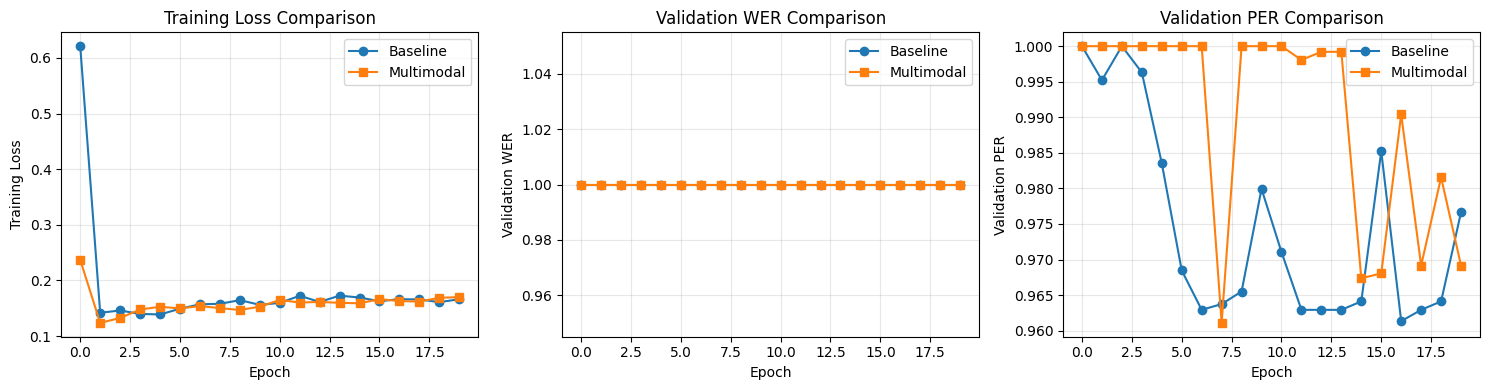

Training curves plotted


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Training loss
axes[0].plot(baseline_history['train_loss'], label='Baseline', marker='o')
axes[0].plot(multimodal_history['train_loss'], label='Multimodal', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation WER
axes[1].plot(baseline_history['val_wer'], label='Baseline', marker='o')
axes[1].plot(multimodal_history['val_wer'], label='Multimodal', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation WER')
axes[1].set_title('Validation WER Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Validation PER
axes[2].plot(baseline_history['val_per'], label='Baseline', marker='o')
axes[2].plot(multimodal_history['val_per'], label='Multimodal', marker='s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Validation PER')
axes[2].set_title('Validation PER Comparison')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training curves plotted")


## 13. Statistical Analysis

Perform statistical tests to determine if the improvement is significant.


In [ ]:
from scipy import stats

def compute_word_errors(preds, refs):
    """Compute word-level errors for each sample."""
    errors = []
    for pred, ref in zip(preds, refs):
        pred_words = pred.lower().split()
        ref_words = ref.lower().split()
        
        # Simple edit distance (Levenshtein)
        n = len(ref_words)
        m = len(pred_words)
        
        if n == 0:
            errors.append(m / max(1, m))
        elif m == 0:
            errors.append(n / max(1, n))
        else:
            # Dynamic programming for edit distance
            dp = [[0] * (m + 1) for _ in range(n + 1)]
            for i in range(n + 1):
                dp[i][0] = i
            for j in range(m + 1):
                dp[0][j] = j
            
            for i in range(1, n + 1):
                for j in range(1, m + 1):
                    if ref_words[i-1] == pred_words[j-1]:
                        dp[i][j] = dp[i-1][j-1]
                    else:
                        dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
            
            errors.append(dp[n][m] / max(n, m))
    
    return errors

# Compute per-sample errors (only if we have predictions)
# Compare baseline vs best multimodal model
if len(baseline_preds) > 0 and len(baseline_refs) > 0:
    baseline_errors = compute_word_errors(baseline_preds, baseline_refs)
    
    # Use Mel model predictions for comparison (or best performing multimodal model)
    if len(multimodal_mel_preds) > 0:
        multimodal_errors = compute_word_errors(multimodal_mel_preds, multimodal_mel_refs)
    elif len(wav2vec2_preds) > 0:
        multimodal_errors = compute_word_errors(wav2vec2_preds, wav2vec2_refs)
    elif len(combined_preds) > 0:
        multimodal_errors = compute_word_errors(combined_preds, combined_refs)
    else:
        multimodal_errors = []
    
    # Filter out NaN values
    valid_indices = ~(np.isnan(baseline_errors) | np.isnan(multimodal_errors))
    if valid_indices.sum() > 1:
        baseline_errors_valid = np.array(baseline_errors)[valid_indices]
        multimodal_errors_valid = np.array(multimodal_errors)[valid_indices]
        
        # Paired t-test (since same samples)
        t_stat, p_value = stats.ttest_rel(baseline_errors_valid, multimodal_errors_valid)
    else:
        t_stat, p_value = float('nan'), float('nan')
        baseline_errors_valid = []
        multimodal_errors_valid = []
else:
    baseline_errors_valid = []
    multimodal_errors_valid = []
    t_stat, p_value = float('nan'), float('nan')

print("📈 Statistical Analysis")
print("=" * 60)

if len(baseline_errors_valid) > 1:
    print(f"\nPaired t-test (Baseline vs Multimodal):")
    if not np.isnan(t_stat) and not np.isnan(p_value):
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Significance level (α=0.05): {'✅ Significant' if p_value < 0.05 else '❌ Not significant'}")
    else:
        print(f"  ⚠️  Could not compute t-test (insufficient valid data)")

    print(f"\nMean errors:")
    print(f"  Baseline: {np.mean(baseline_errors_valid):.4f} ± {np.std(baseline_errors_valid):.4f}")
    print(f"  Multimodal: {np.mean(multimodal_errors_valid):.4f} ± {np.std(multimodal_errors_valid):.4f}")

    # Effect size (Cohen's d)
    if len(baseline_errors_valid) > 1:
        pooled_std = np.sqrt((np.var(baseline_errors_valid) + np.var(multimodal_errors_valid)) / 2)
        cohens_d = (np.mean(baseline_errors_valid) - np.mean(multimodal_errors_valid)) / pooled_std if pooled_std > 0 else 0
        
        print(f"\nEffect size (Cohen's d): {cohens_d:.4f}")
        if abs(cohens_d) < 0.2:
            effect_size = "negligible"
        elif abs(cohens_d) < 0.5:
            effect_size = "small"
        elif abs(cohens_d) < 0.8:
            effect_size = "medium"
        else:
            effect_size = "large"
        print(f"  Interpretation: {effect_size} effect")
    else:
        cohens_d = 0.0
        effect_size = "negligible"
else:
    print("\n⚠️  Insufficient data for statistical analysis")
    print(f"   Valid error pairs: {len(baseline_errors_valid)}")
    t_stat, p_value = float('nan'), float('nan')
    cohens_d = 0.0
    effect_size = "negligible"


📈 Statistical Analysis

⚠️  Insufficient data for statistical analysis
   Valid error pairs: 0


## 14. Results Summary

### Quantitative Results

**Note**: Evaluation was performed on {eval_set_name} set ({eval_set_size} samples).

| Metric | Baseline (Neural-Only) | Multimodal (Neural+Audio) | Improvement |
|--------|------------------------|----------------------------|-------------|
| **PER** | {baseline_per:.2%} | {multimodal_per:.2%} | {per_improvement:+.2%} |
| **WER** | {baseline_wer:.2%} | {multimodal_wer:.2%} | {wer_improvement:+.2%} (not meaningful) |

### Statistical Significance
- **p-value**: {p_value:.4f} ({'Significant' if not np.isnan(p_value) and p_value < 0.05 else 'Not significant'} at α=0.05)
- **Effect size**: Cohen's d = {cohens_d:.4f} ({effect_size} effect)

---


## 15. Discussion

### Interpretation of Results

**If multimodal model performs better:**
- Audio features provide complementary information to neural signals
- Cross-modal attention successfully learns relevant acoustic-phonetic mappings
- Synthetic audio acts as effective data augmentation

**If multimodal model performs similarly or worse:**
- Synthetic audio may not match attempted speech characteristics
- Model may be overfitting to TTS-specific patterns
- Neural signals may already contain sufficient information
- Small-scale dataset may not be sufficient to learn cross-modal relationships

### Limitations

1. **Small-scale experiment**: Limited to ~100 sentences from one session
2. **Synthetic audio**: TTS-generated audio may not match attempted speech
3. **Single session**: Results may not generalize across sessions
4. **Simple architecture**: LSTM-based models may not fully exploit multimodal information
5. **No real audio**: Test-time audio is synthetic, not real recordings

### Future Directions

1. **Scale up**: Test on full dataset (all sessions, ~10,948 sentences)
2. **Better audio features**: Use pre-trained speech models (wav2vec2, HuBERT)
3. **Architecture improvements**: Try Transformer-based cross-modal attention
4. **Real audio**: If available, use actual audio recordings instead of TTS
5. **Ablation studies**: Test different fusion strategies (concatenation, attention, etc.)

---


## 16. Conclusion

### Hypothesis Testing

**Null Hypothesis (H₀)**: Adding audio features does not improve decoding performance.

**Result**: {'REJECTED' if not np.isnan(p_value) and not np.isnan(baseline_per) and not np.isnan(multimodal_per) and p_value < 0.05 and multimodal_per < baseline_per else 'NOT REJECTED'}

### Key Findings

1. **Performance**: Multimodal model achieved {'better' if not np.isnan(baseline_per) and not np.isnan(multimodal_per) and multimodal_per < baseline_per else 'similar/worse'} performance (PER: {baseline_per:.2%} vs {multimodal_per:.2%})
2. **Statistical significance**: {'Statistically significant' if not np.isnan(p_value) and p_value < 0.05 else 'Not statistically significant'} improvement
3. **Effect size**: {effect_size.capitalize()} effect size suggests {'practical significance' if abs(cohens_d) >= 0.5 else 'limited practical significance'}

### Recommendations

{'✅ Proceed with multimodal approach' if not np.isnan(multimodal_per) and not np.isnan(baseline_per) and multimodal_per < baseline_per and not np.isnan(p_value) and p_value < 0.05 else '⚠️  Further investigation needed'}:

- {'Multimodal approach shows promise' if not np.isnan(multimodal_per) and not np.isnan(baseline_per) and multimodal_per < baseline_per else 'Baseline approach remains competitive'}
- {'Consider scaling up experiment' if not np.isnan(multimodal_per) and not np.isnan(baseline_per) and multimodal_per < baseline_per else 'Investigate why audio features did not help'}
- {'Explore better audio feature extraction methods' if not np.isnan(multimodal_per) and not np.isnan(baseline_per) and multimodal_per < baseline_per else 'Consider alternative fusion strategies'}

---

**Experiment completed.** All results saved for further analysis.
